# Benchmark Data Visualization
This notebook compares EC and Replication benchmark results for `success_performance.med`, `success_performance.p(90)`, and `reqs.rate`.

For better visualization, it generates:
- One chart for each metric (med, p90, reqs.rate), comparing EC and Replication for each payload size and virtual user combination.
- Grouped comparisons by bandwidth, payload size, and virtual users to show performance scaling across different dimensions.

In [12]:
import json
import glob
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Suffix for selecting benchmark results
suffix = "/write_avgnet/"

# Path to your benchmark results directory
results_dir = './results_store/_final/'
ec_pattern = results_dir + f'erasure{suffix}/_write_*_*.json'
replication_pattern = results_dir + f'replication{suffix}/_write_*_*.json'

# Helper to extract data from files

def extract_data(files, system_type):
    data = []
    for file in files:
        # Updated regex: matches kbit, mbit, gbit
        match = re.search(r'_write_(.+?)_(\d+)vu(?:_([0-9]+(?:kbit|mbit|gbit)))?\.json', file)
        if not match:
            continue
        payload_size = match.group(1)
        if payload_size.endswith('b'):
            payload_size = payload_size[:-1]
        try:
            payload_size = int(payload_size)
        except ValueError:
            pass
        virtual_user = match.group(2)
        bandwidth = match.group(3) if match.group(3) else 'unlimited'
        with open(file) as f:
            j = json.load(f)
            try:
                med = j['summary']['success_performance'].get('med', 0)
                p90 = j['summary']['success_performance'].get('p(90)', 0)
                avg = j['summary']['success_performance'].get('avg', 0)
            except (KeyError, TypeError):
                med = 0
                p90 = 0
                avg = 0
            try:
                rate = j['summary']['reqs'].get('rate', 0)
            except (KeyError, TypeError):
                rate = 0
            data.append({
                'system': system_type,
                'payload_size': payload_size,
                'virtual_user': int(virtual_user),
                'bandwidth': bandwidth,
                'med': med,
                'p90': p90,
                'avg': avg,
                'rate': rate
            })
    return data

def bandwidth_to_num(bw):
    if bw == 'unlimited':
        return float('inf')
    m = re.match(r'(\d+)(kbit|mbit|gbit)', bw)
    if not m:
        return float('inf')
    val, unit = int(m.group(1)), m.group(2)
    if unit == 'kbit':
        return val
    elif unit == 'mbit':
        return val * 1000
    elif unit == 'gbit':
        return val * 1000 * 1000
    return float('inf')

# Collect EC and Replication data
files_ec = glob.glob(ec_pattern)
files_replication = glob.glob(replication_pattern)
data = extract_data(files_ec, 'EC') + extract_data(files_replication, 'Replication')
df = pd.DataFrame(data)
if not df.empty:
    # Add bandwidth_num for correct sorting
    df['bandwidth_num'] = df['bandwidth'].apply(bandwidth_to_num)
    # Sort by payload_size, virtual_user, bandwidth_num, then system for grouped comparison
    df = df.sort_values(['payload_size', 'virtual_user', 'bandwidth_num', 'system'])
    df['combo'] = df.apply(lambda row: f"{row['payload_size']}B_{row['virtual_user']}vu_{row['bandwidth']}", axis=1)
    df.reset_index(drop=True, inplace=True)
df

,system,payload_size,virtual_user,bandwidth,med,p90,avg,rate,bandwidth_num,combo
0,EC,200000,1,10mbit,699.992802,723.726307,701.948700,1.409262,10000,200000B_1vu_10mbit
1,Replication,200000,1,10mbit,1073.896833,1086.421647,1065.650607,0.931688,10000,200000B_1vu_10mbit
2,EC,200000,1,25mbit,341.796174,399.206527,347.620375,2.816840,25000,200000B_1vu_25mbit
3,Replication,200000,1,25mbit,429.650143,466.753251,427.348248,2.297152,25000,200000B_1vu_25mbit
4,EC,200000,1,40mbit,261.041856,360.153438,275.510498,3.531695,40000,200000B_1vu_40mbit
5,Replication,200000,1,40mbit,268.192058,289.197103,266.721019,3.639365,40000,200000B_1vu_40mbit
6,EC,200000,1,55mbit,236.579951,353.503377,253.428548,3.829072,55000,200000B_1vu_55mbit
7,Replication,200000,1,55mbit,194.562242,207.905265,193.301509,4.969445,55000,200000B_1vu_55mbit
8,EC,200000,1,70mbit,224.866249,365.015640,241.722793,4.010621,70000,200000B_1vu_70mbit
9,Replication,200000,1,70mbit,152.595633,163.087706,151.345583,6.277621,70000,200000B_1vu_70mbit


/tmp/ipykernel_3601799/3066400088.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


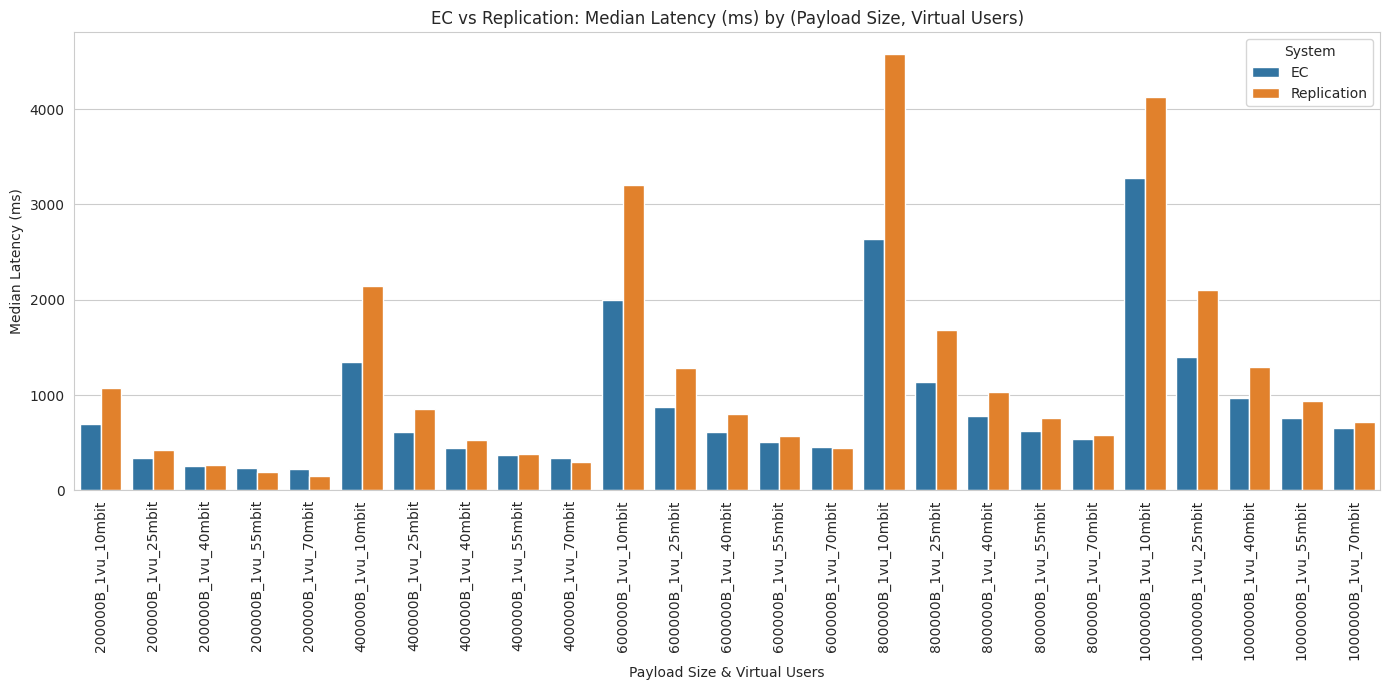

/tmp/ipykernel_3601799/3066400088.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


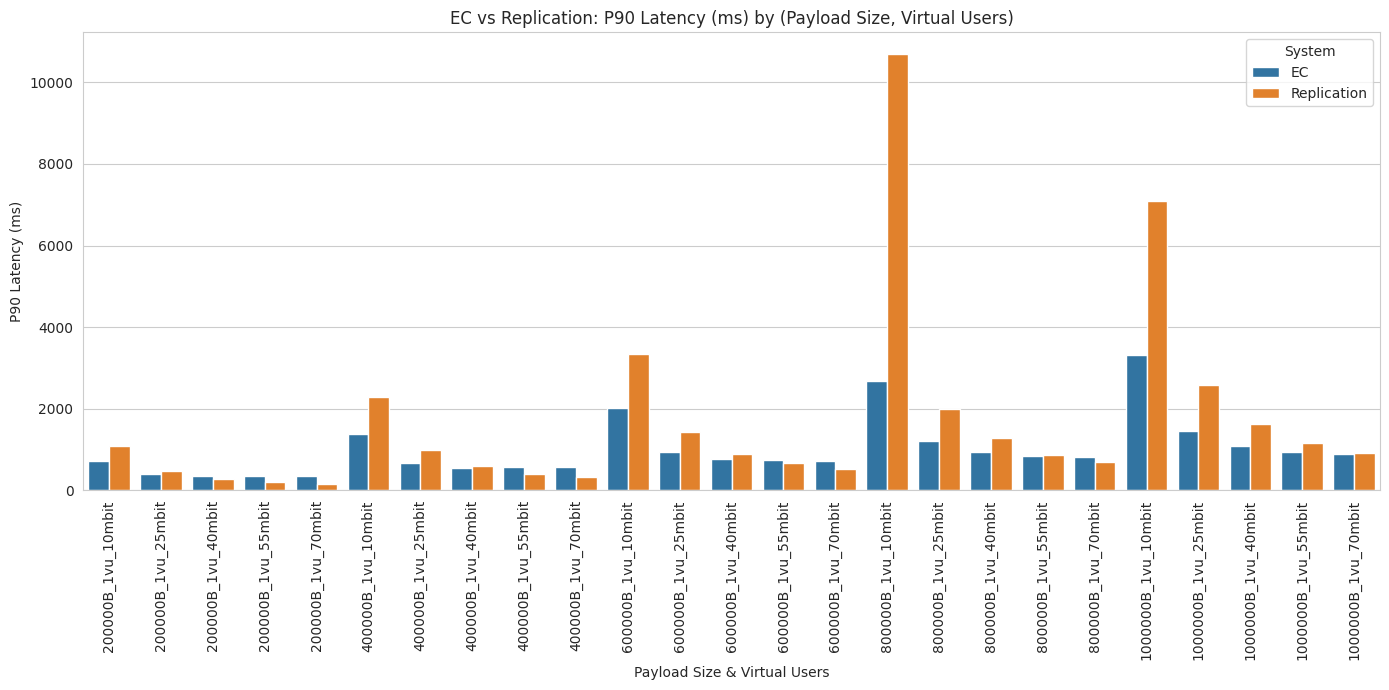

/tmp/ipykernel_3601799/3066400088.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


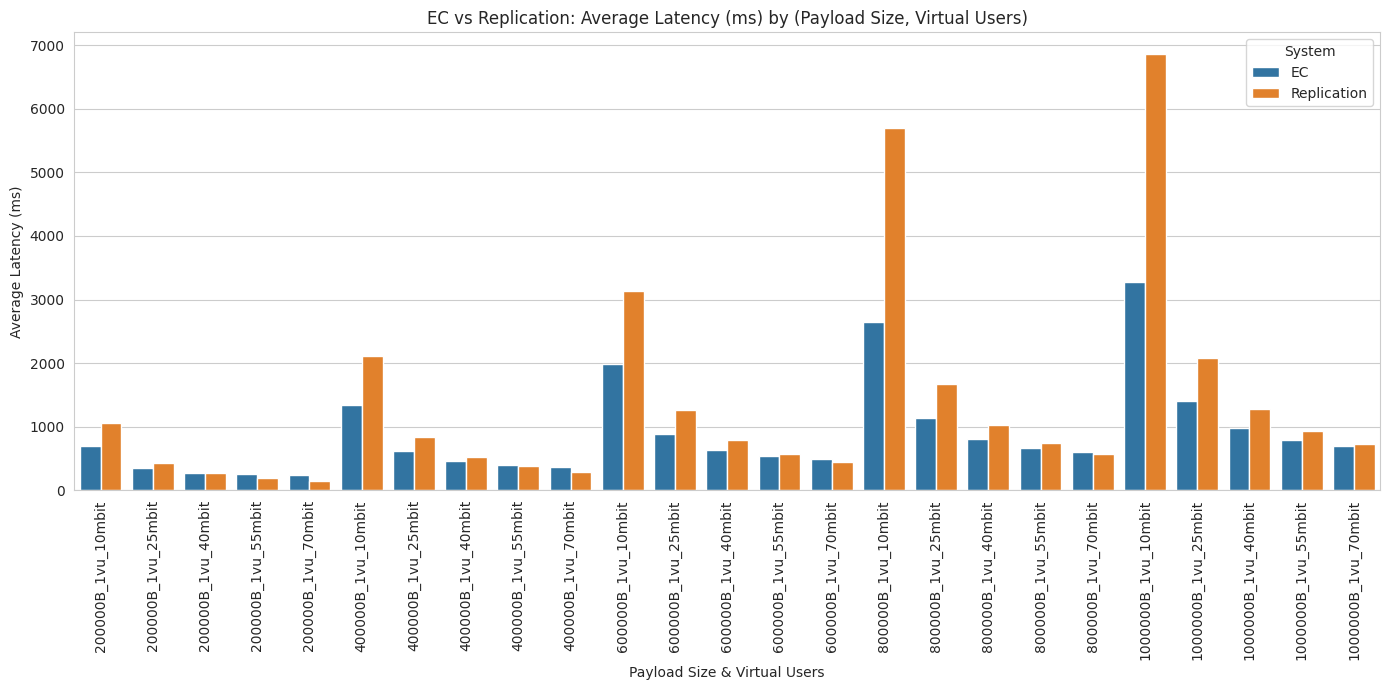

/tmp/ipykernel_3601799/3066400088.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


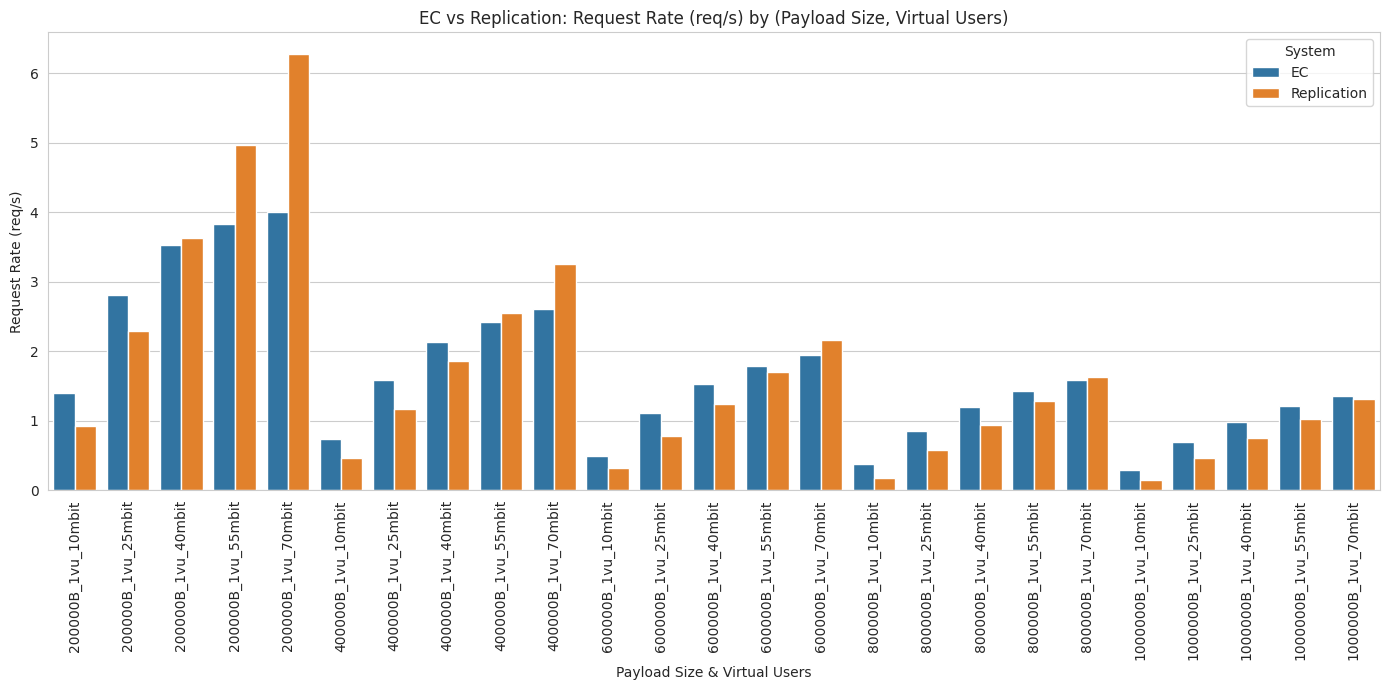

In [13]:
# Plotting: Compare EC vs Replication for each metric, grouped by (payload_size, virtual_user)
sns.set_style("whitegrid")
metrics = ['med', 'p90', 'avg', 'rate']
metric_titles = {'med': 'Median Latency (ms)', 'p90': 'P90 Latency (ms)', 'avg': 'Average Latency (ms)', 'rate': 'Request Rate (req/s)'}

for metric in metrics:
    plt.figure(figsize=(14,7))
    sns.barplot(
        data=df,
        x='combo',
        y=metric,
        hue='system',
        ci=None,
        dodge=True
    )
    plt.title(f'EC vs Replication: {metric_titles[metric]} by (Payload Size, Virtual Users)')
    plt.xlabel('Payload Size & Virtual Users')
    plt.ylabel(metric_titles[metric])
    plt.xticks(rotation=90)
    plt.legend(title='System')
    plt.tight_layout()
    plt.show()

In [14]:
# Create grouped visualizations for bandwidth, payload size, and virtual users

# First, let's check what distinct values we have for each parameter
print(f"Unique bandwidth values: {df['bandwidth'].unique()}")
print(f"Unique payload sizes: {df['payload_size'].unique()}")
print(f"Unique virtual users: {df['virtual_user'].unique()}")

Unique bandwidth values: ['10mbit' '25mbit' '40mbit' '55mbit' '70mbit']
Unique payload sizes: [ 200000  400000  600000  800000 1000000]
Unique virtual users: [1]


/tmp/ipykernel_3601799/4242064581.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bw['payload_vu'] = df_bw.apply(lambda row: f"{row['payload_size']}B_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/4242064581.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


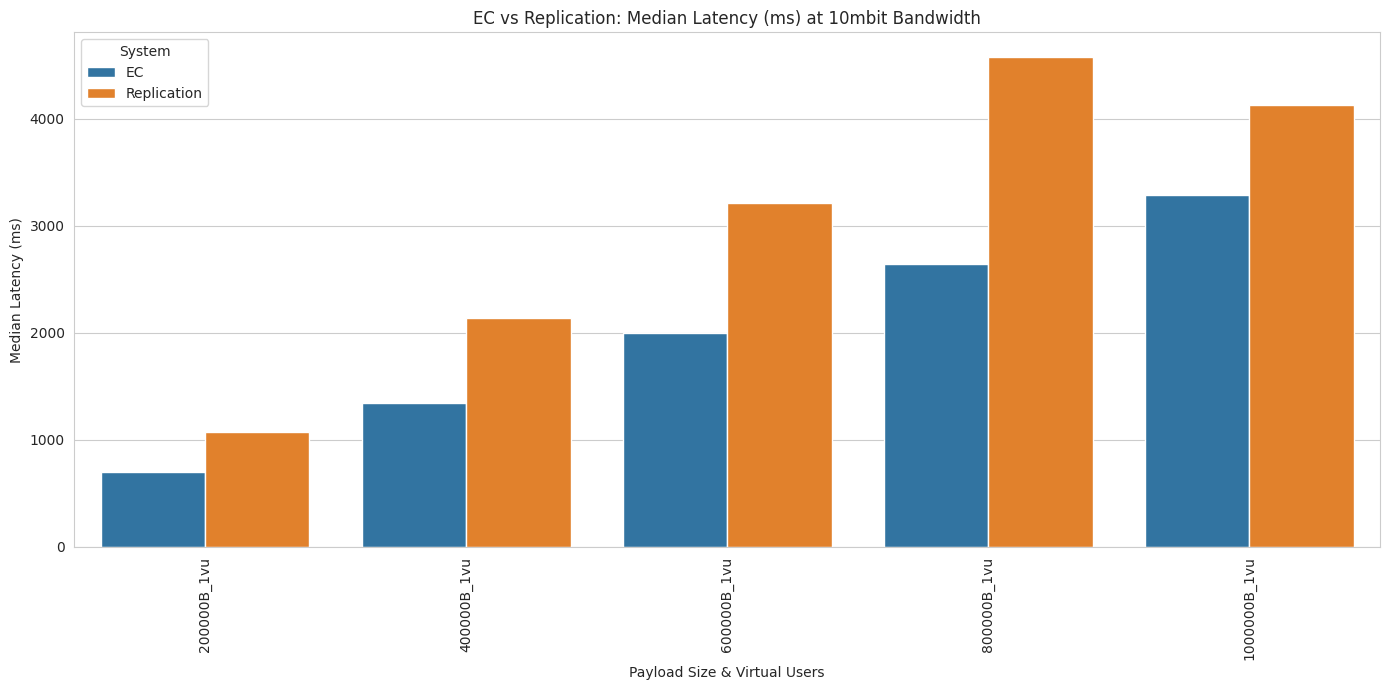

/tmp/ipykernel_3601799/4242064581.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bw['payload_vu'] = df_bw.apply(lambda row: f"{row['payload_size']}B_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/4242064581.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


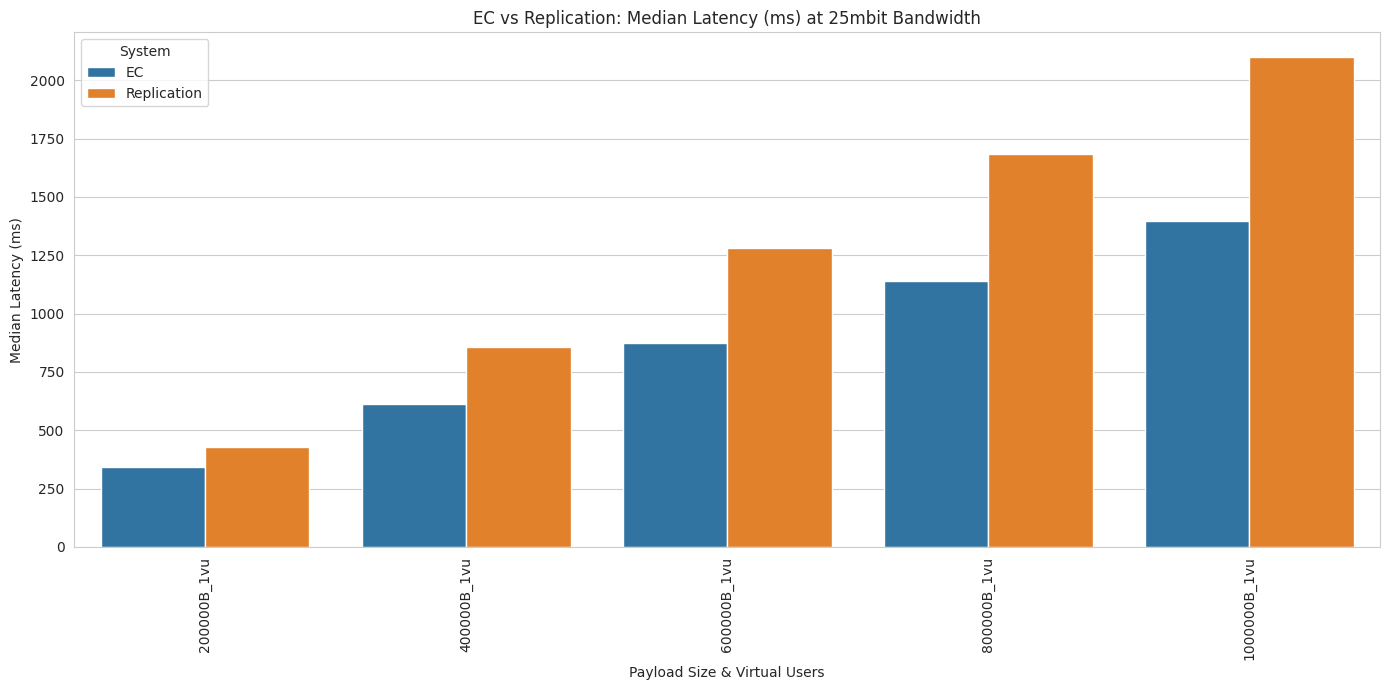

/tmp/ipykernel_3601799/4242064581.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bw['payload_vu'] = df_bw.apply(lambda row: f"{row['payload_size']}B_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/4242064581.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


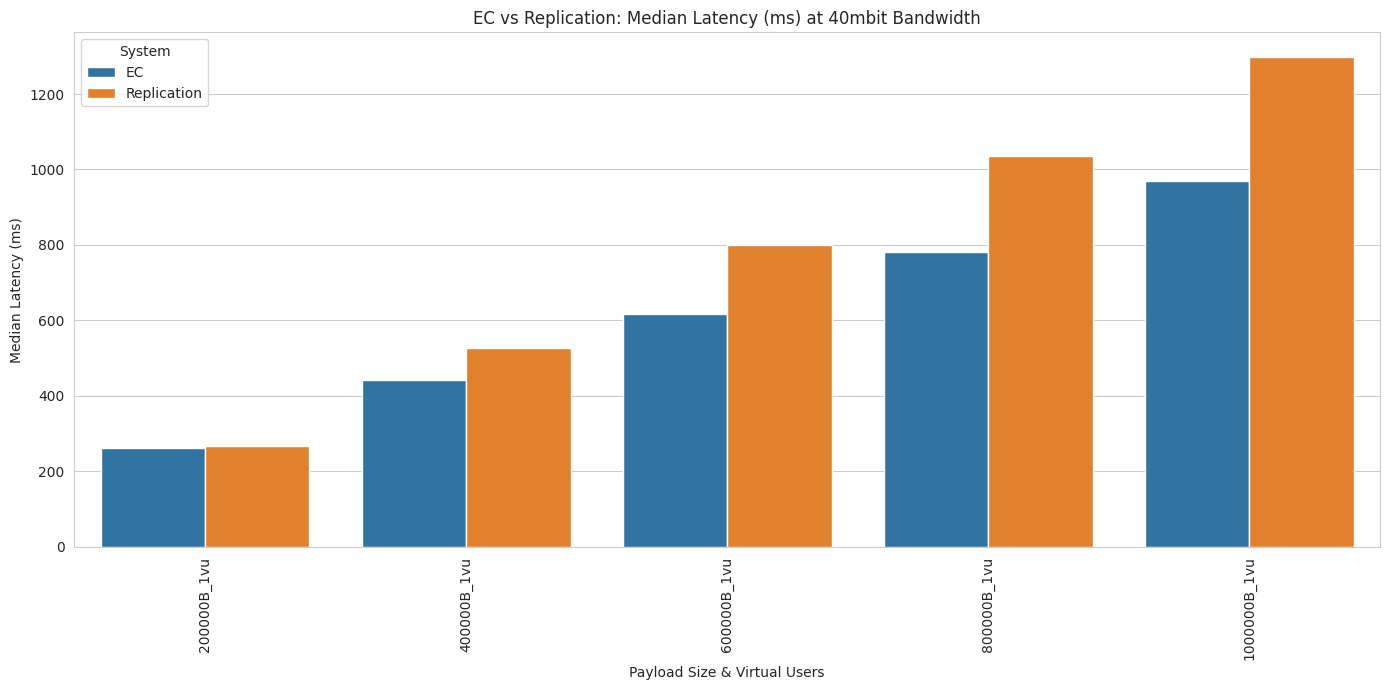

/tmp/ipykernel_3601799/4242064581.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bw['payload_vu'] = df_bw.apply(lambda row: f"{row['payload_size']}B_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/4242064581.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


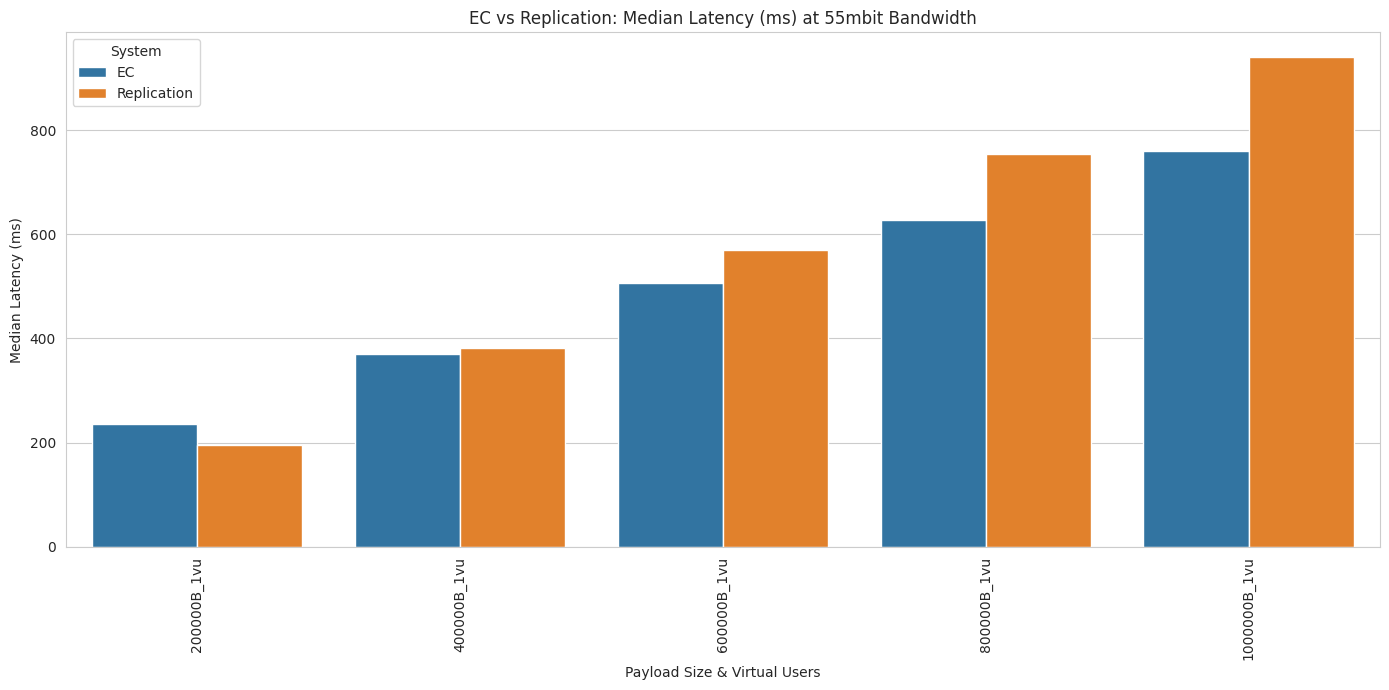

/tmp/ipykernel_3601799/4242064581.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bw['payload_vu'] = df_bw.apply(lambda row: f"{row['payload_size']}B_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/4242064581.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


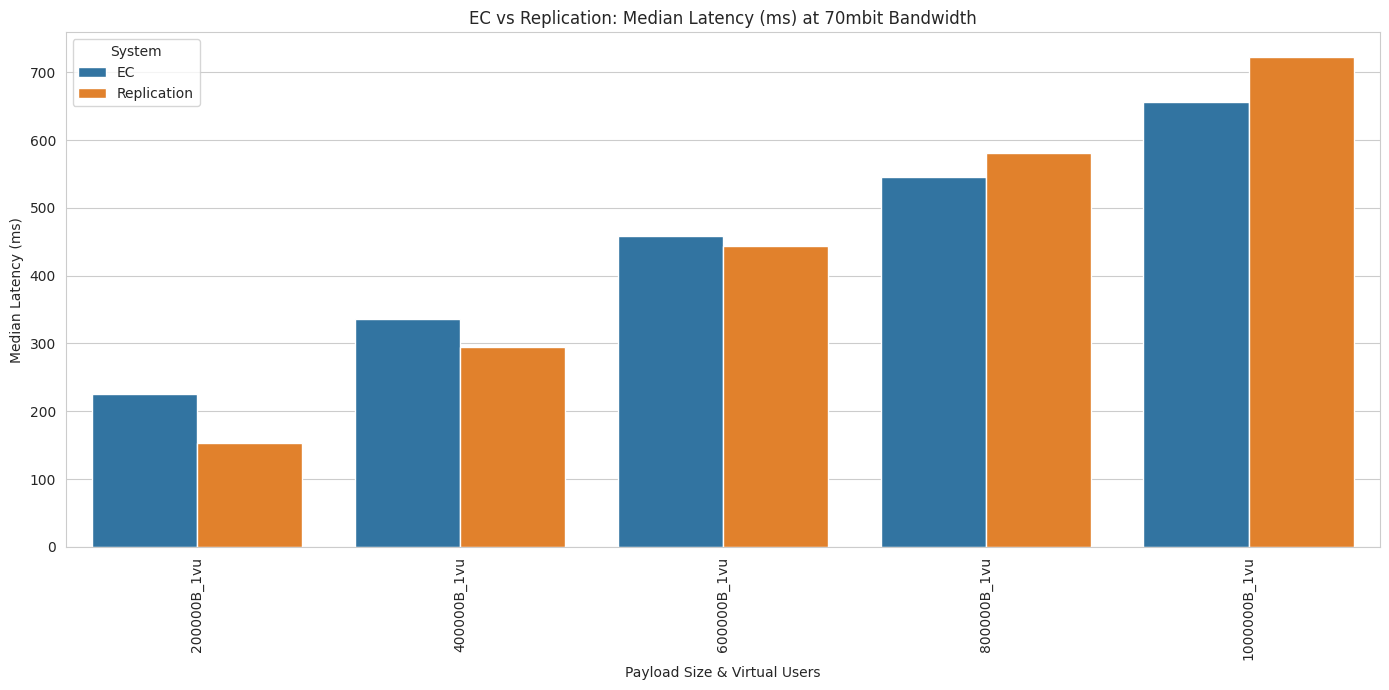

/tmp/ipykernel_3601799/4242064581.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bw['payload_vu'] = df_bw.apply(lambda row: f"{row['payload_size']}B_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/4242064581.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


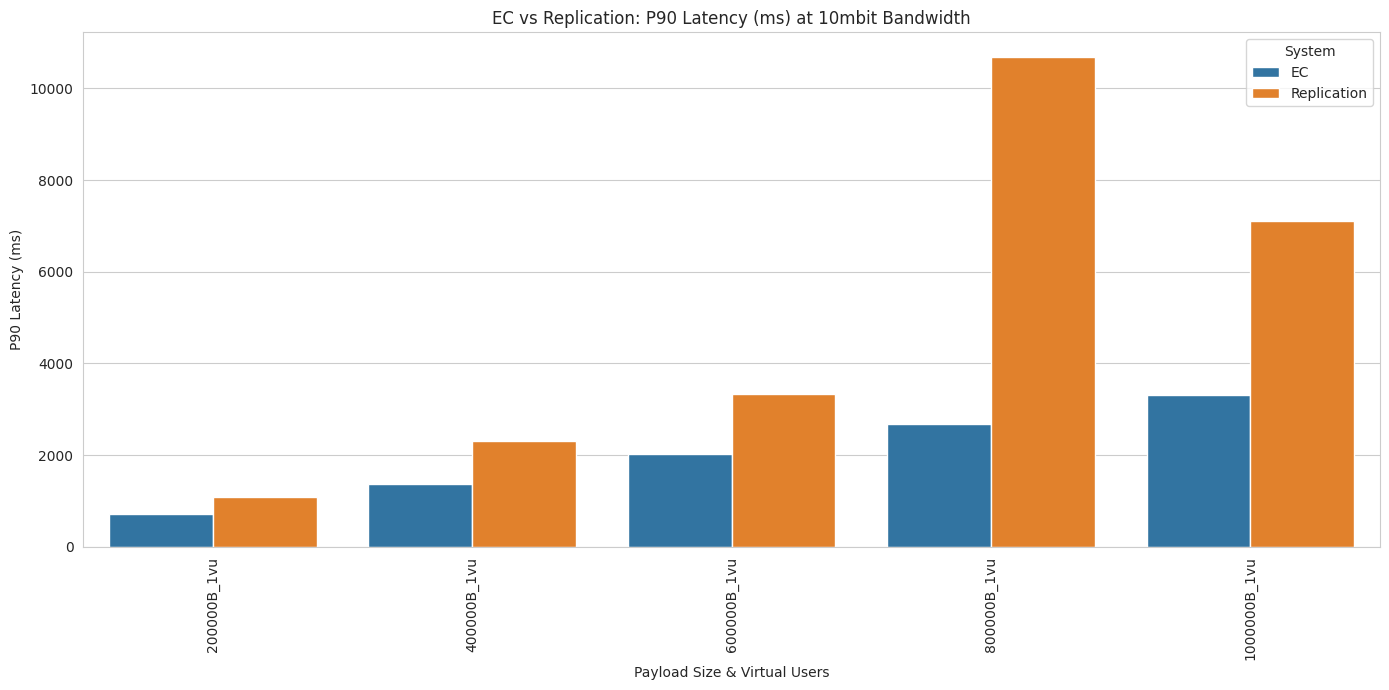

/tmp/ipykernel_3601799/4242064581.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bw['payload_vu'] = df_bw.apply(lambda row: f"{row['payload_size']}B_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/4242064581.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


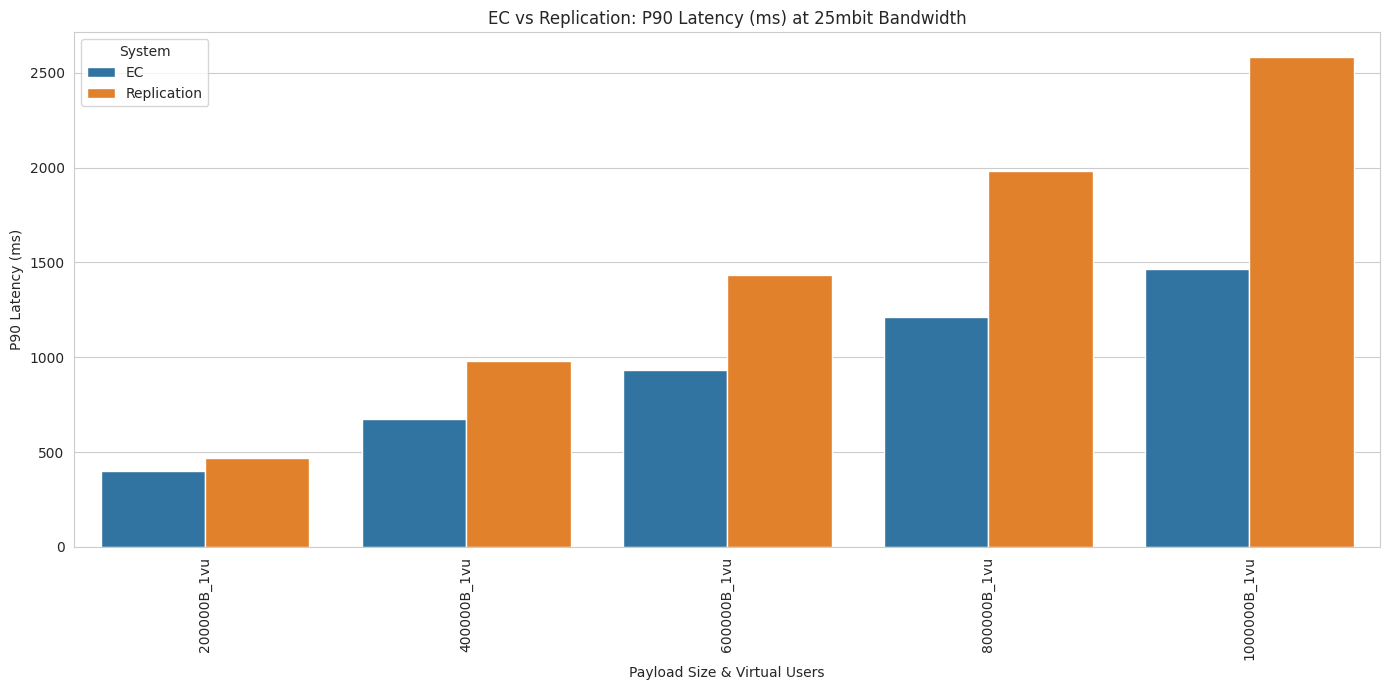

/tmp/ipykernel_3601799/4242064581.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bw['payload_vu'] = df_bw.apply(lambda row: f"{row['payload_size']}B_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/4242064581.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


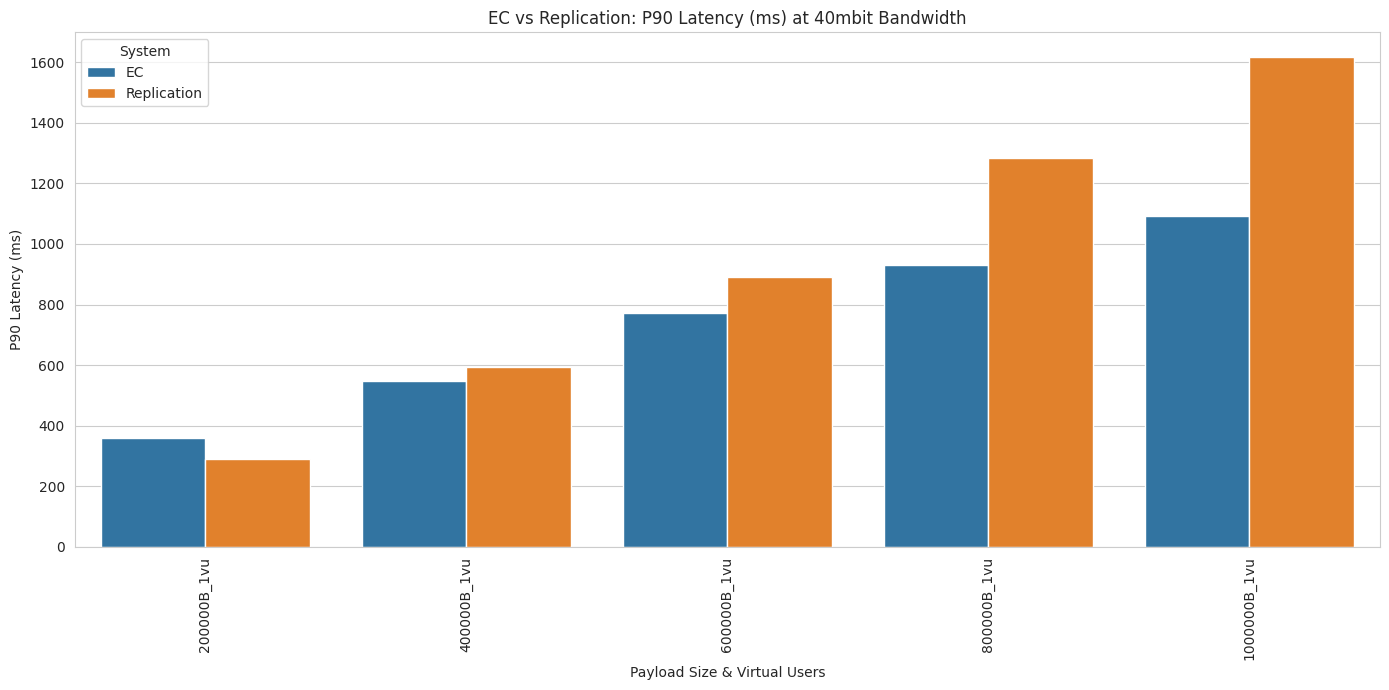

/tmp/ipykernel_3601799/4242064581.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bw['payload_vu'] = df_bw.apply(lambda row: f"{row['payload_size']}B_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/4242064581.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


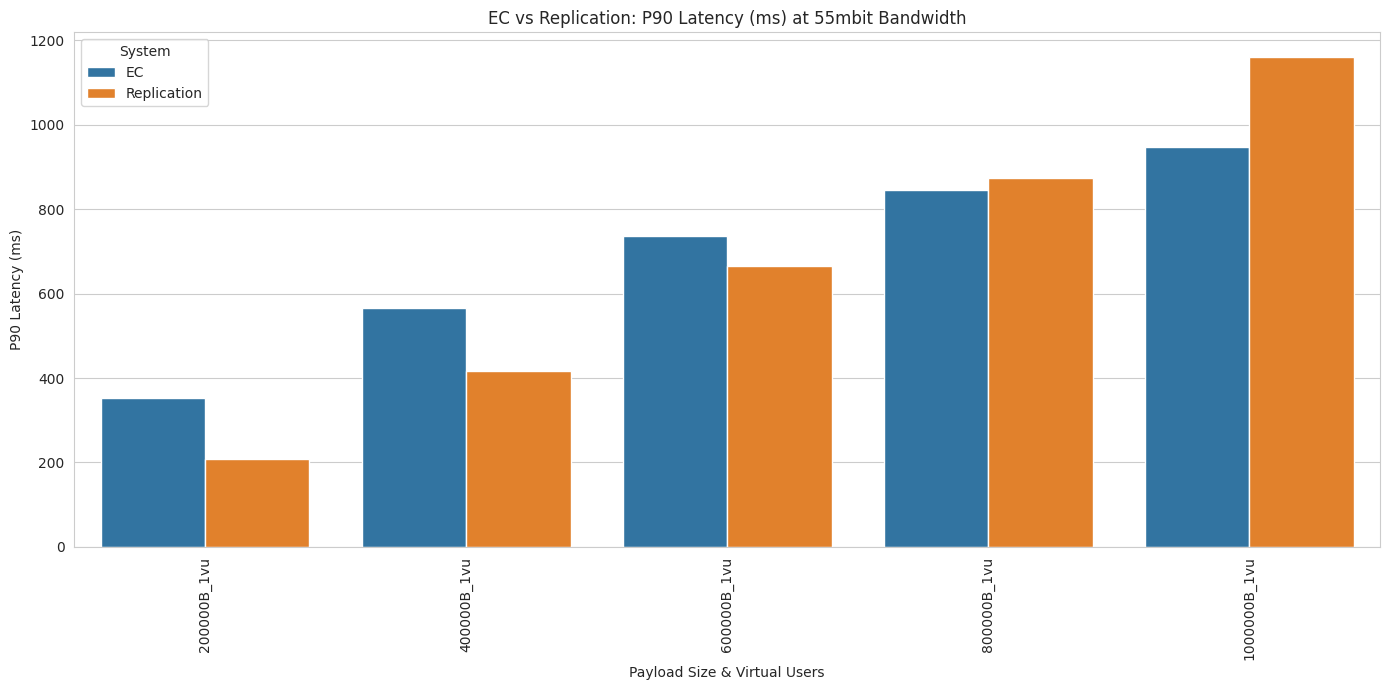

/tmp/ipykernel_3601799/4242064581.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bw['payload_vu'] = df_bw.apply(lambda row: f"{row['payload_size']}B_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/4242064581.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


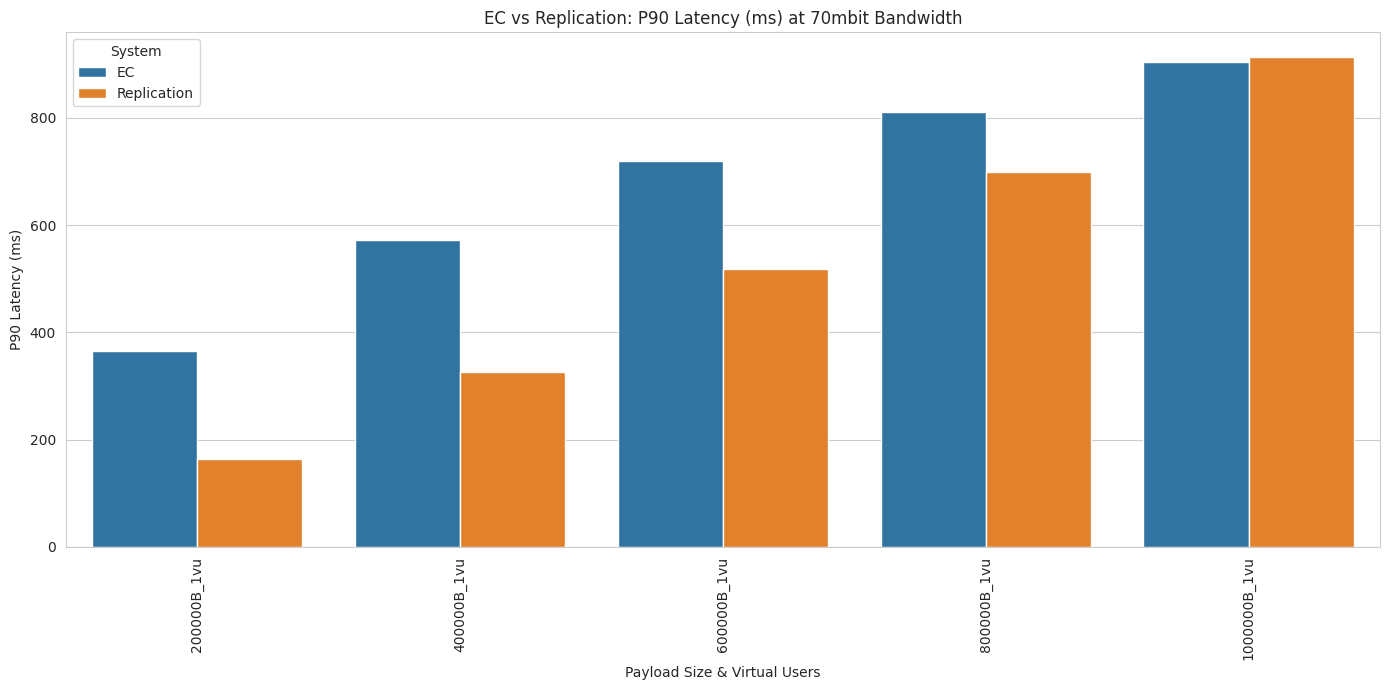

/tmp/ipykernel_3601799/4242064581.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bw['payload_vu'] = df_bw.apply(lambda row: f"{row['payload_size']}B_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/4242064581.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


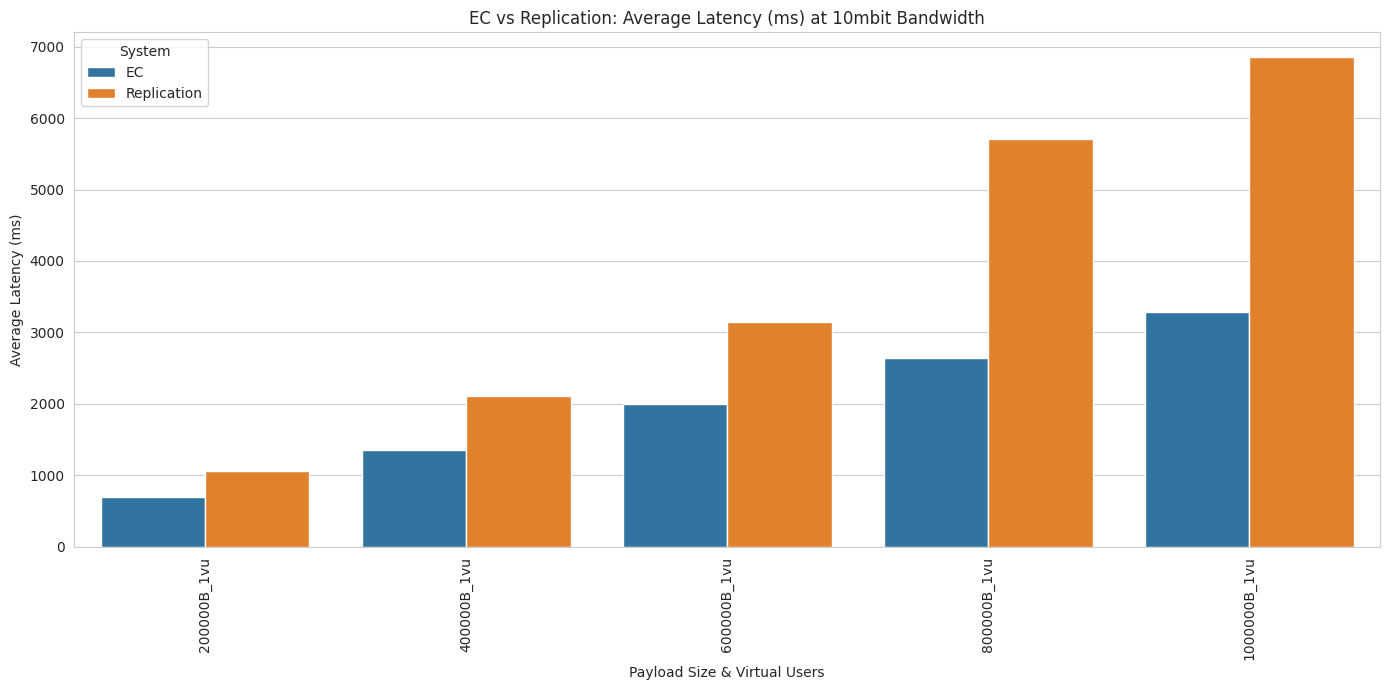

/tmp/ipykernel_3601799/4242064581.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bw['payload_vu'] = df_bw.apply(lambda row: f"{row['payload_size']}B_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/4242064581.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


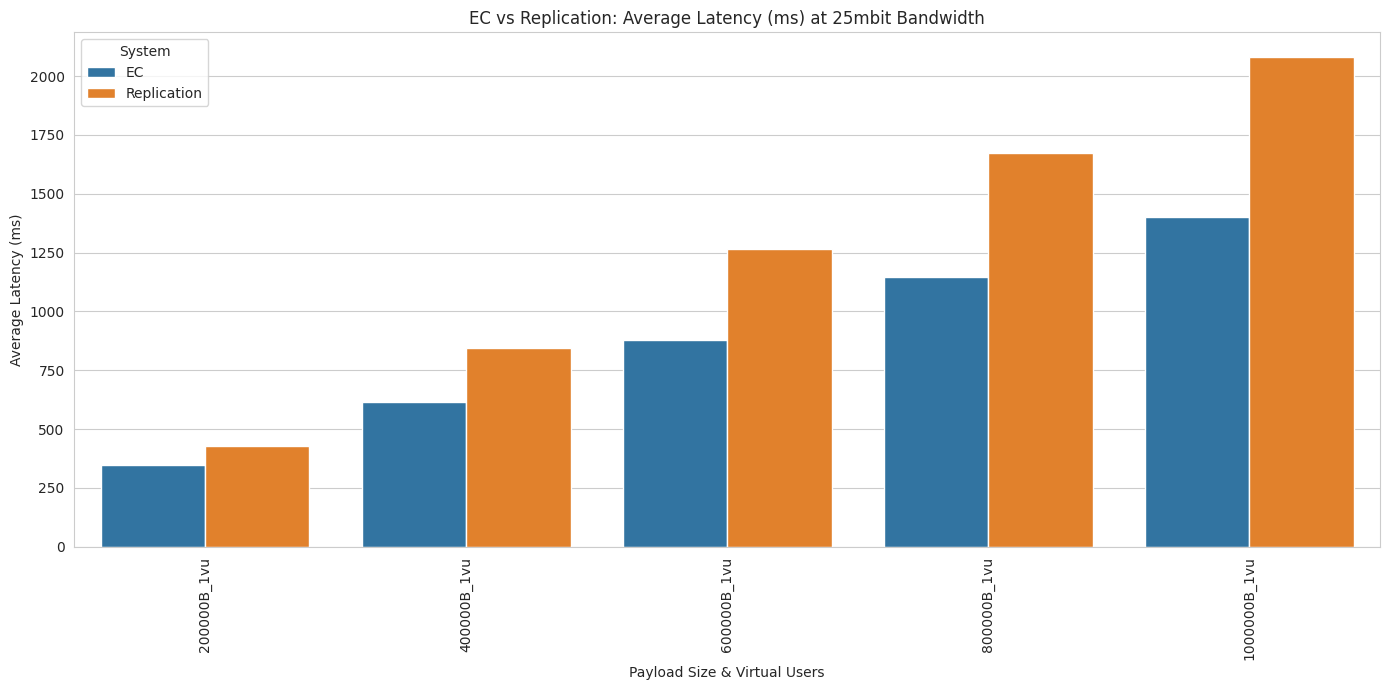

/tmp/ipykernel_3601799/4242064581.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bw['payload_vu'] = df_bw.apply(lambda row: f"{row['payload_size']}B_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/4242064581.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


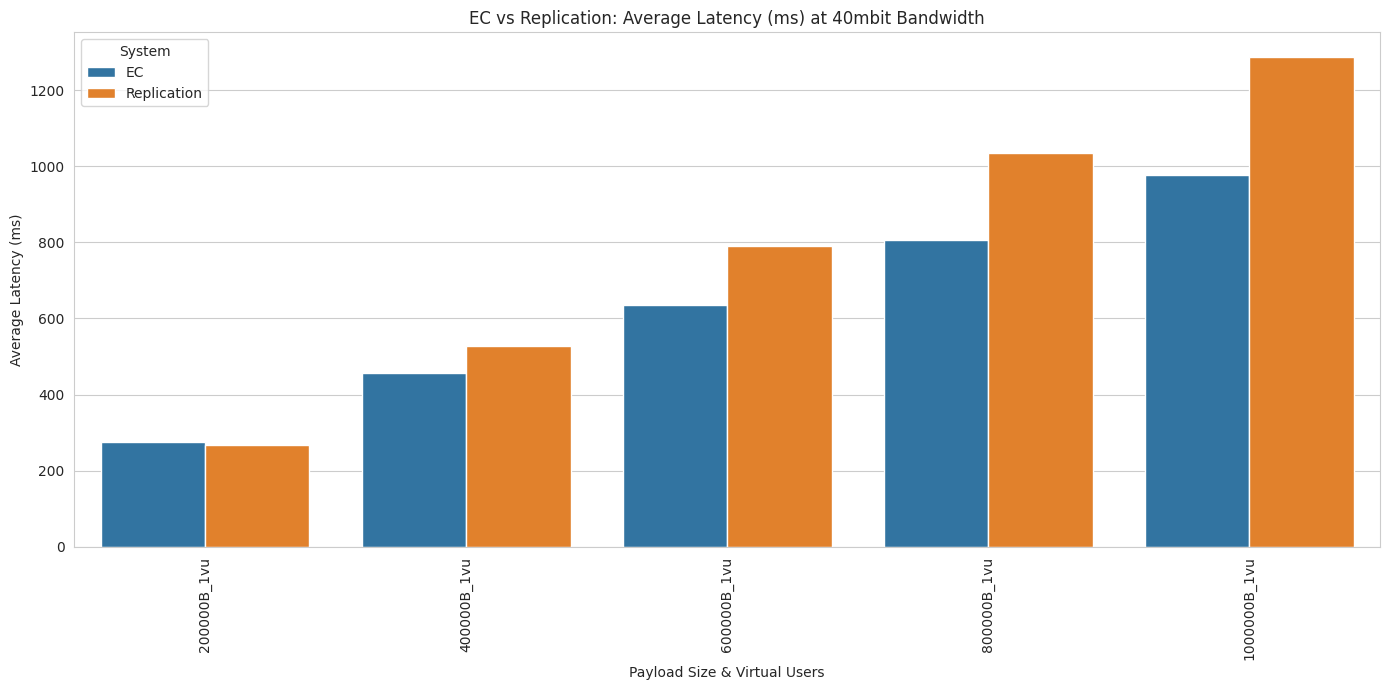

/tmp/ipykernel_3601799/4242064581.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bw['payload_vu'] = df_bw.apply(lambda row: f"{row['payload_size']}B_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/4242064581.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


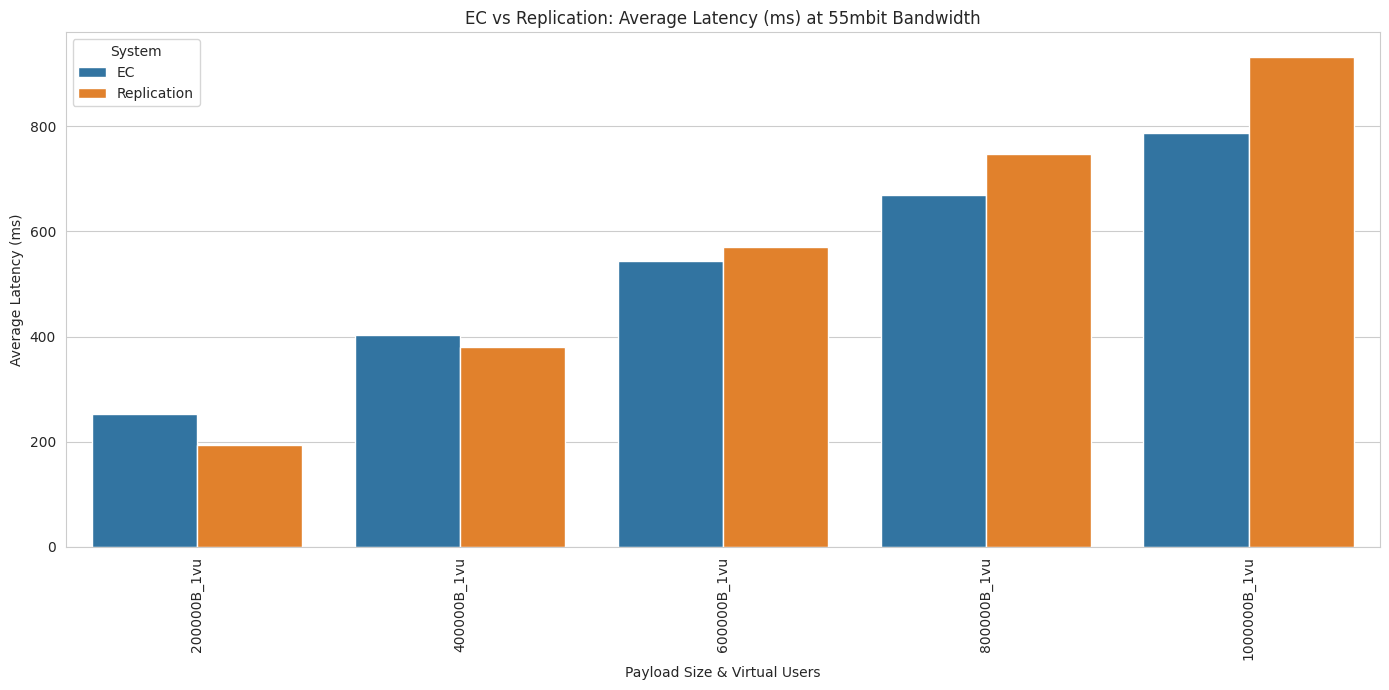

/tmp/ipykernel_3601799/4242064581.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bw['payload_vu'] = df_bw.apply(lambda row: f"{row['payload_size']}B_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/4242064581.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


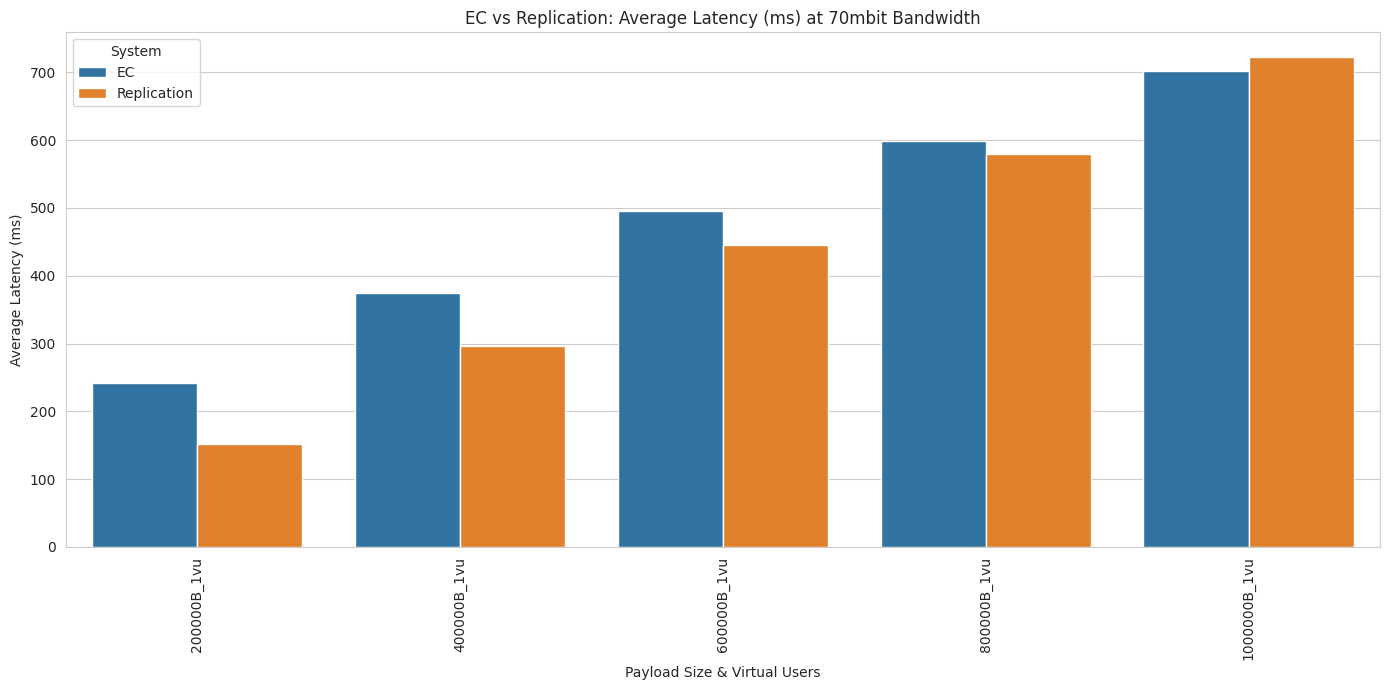

/tmp/ipykernel_3601799/4242064581.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bw['payload_vu'] = df_bw.apply(lambda row: f"{row['payload_size']}B_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/4242064581.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


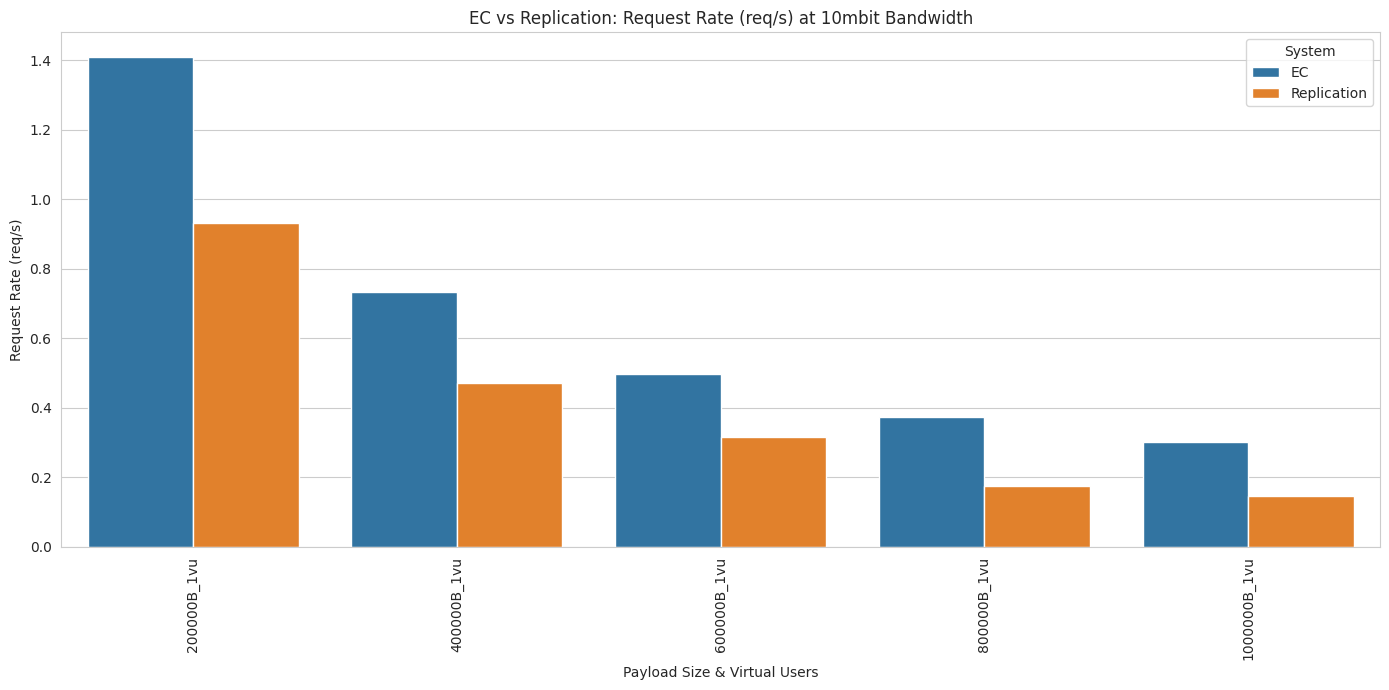

/tmp/ipykernel_3601799/4242064581.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bw['payload_vu'] = df_bw.apply(lambda row: f"{row['payload_size']}B_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/4242064581.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


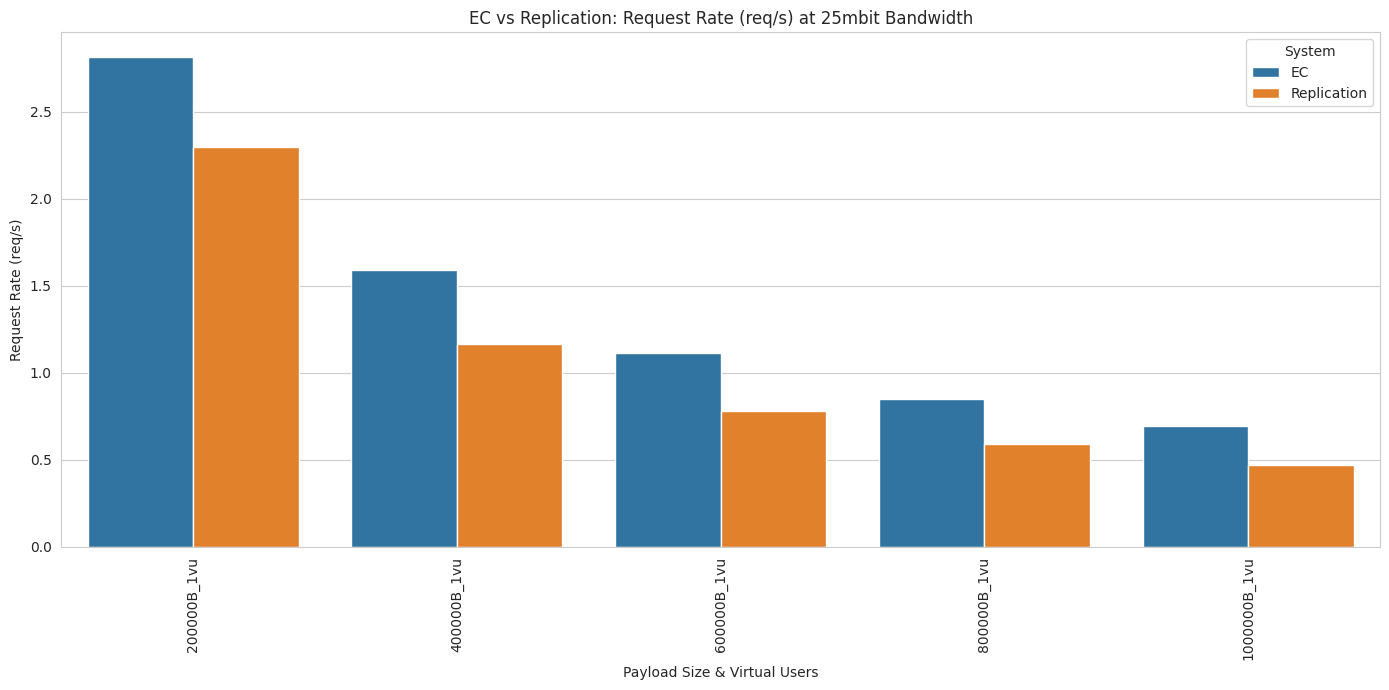

/tmp/ipykernel_3601799/4242064581.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bw['payload_vu'] = df_bw.apply(lambda row: f"{row['payload_size']}B_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/4242064581.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


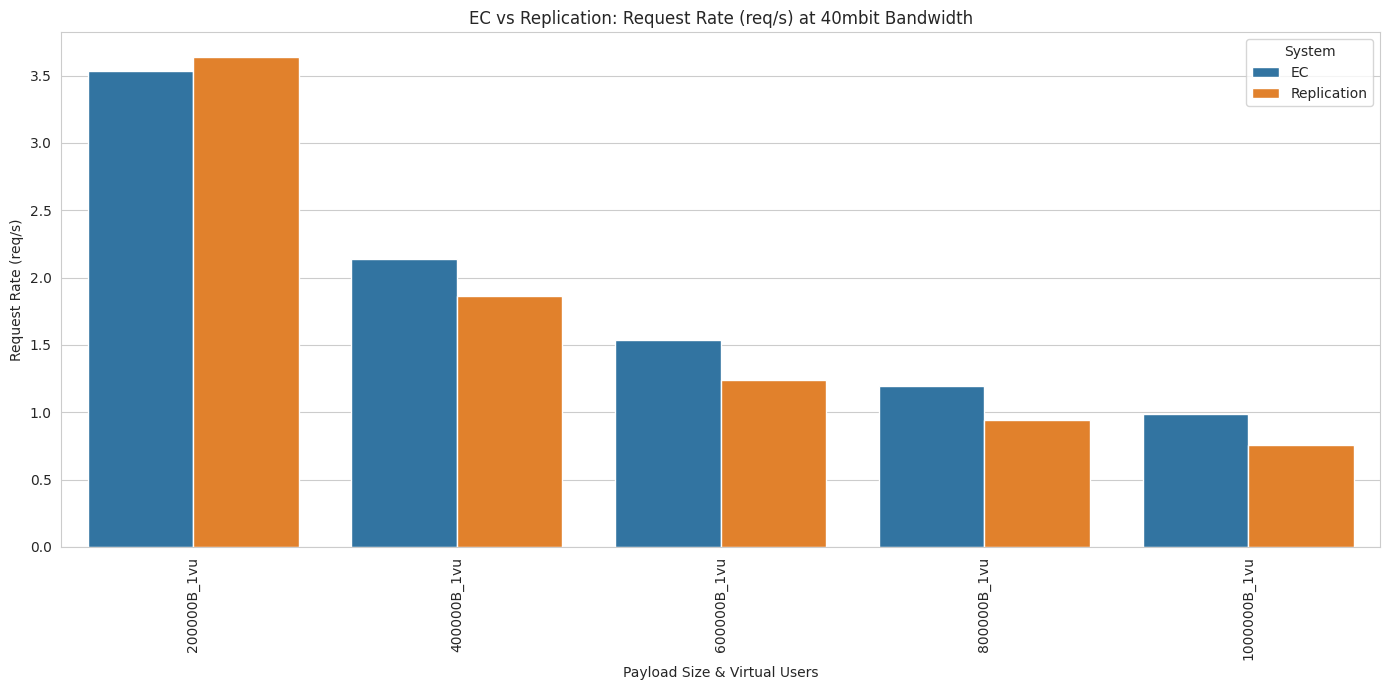

/tmp/ipykernel_3601799/4242064581.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bw['payload_vu'] = df_bw.apply(lambda row: f"{row['payload_size']}B_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/4242064581.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


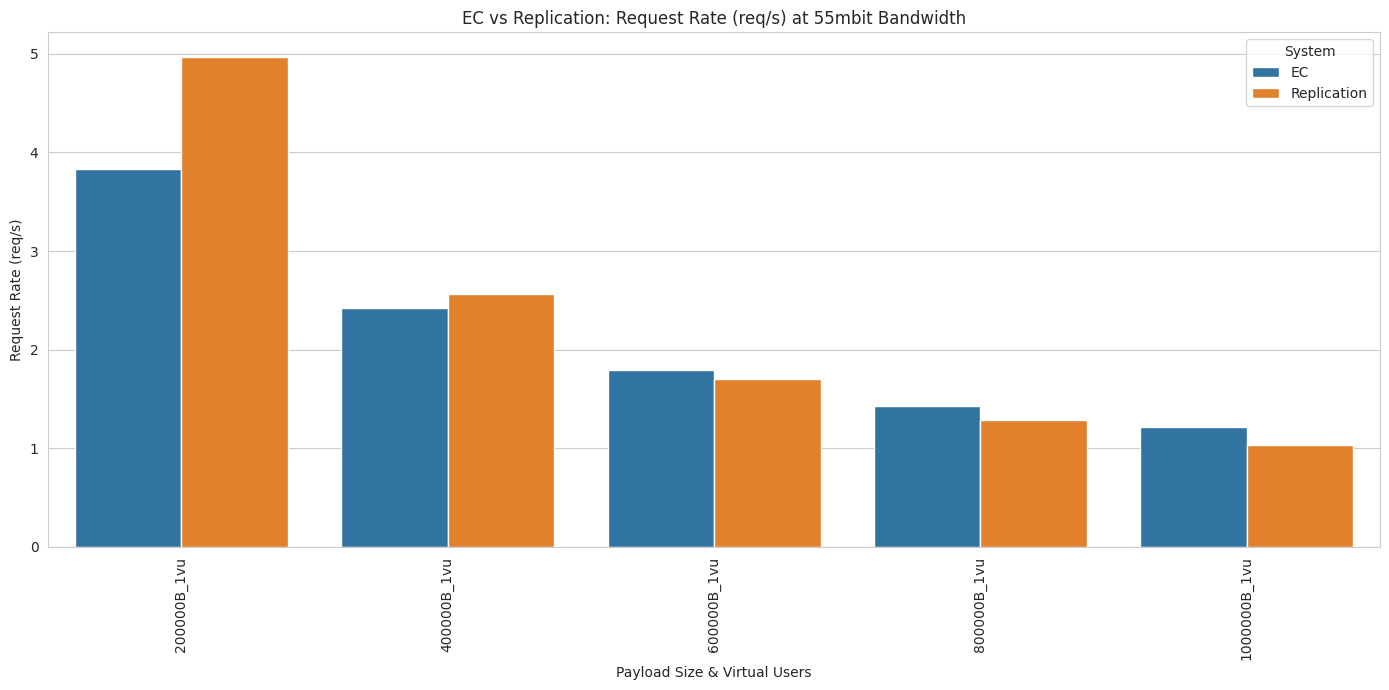

/tmp/ipykernel_3601799/4242064581.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bw['payload_vu'] = df_bw.apply(lambda row: f"{row['payload_size']}B_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/4242064581.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


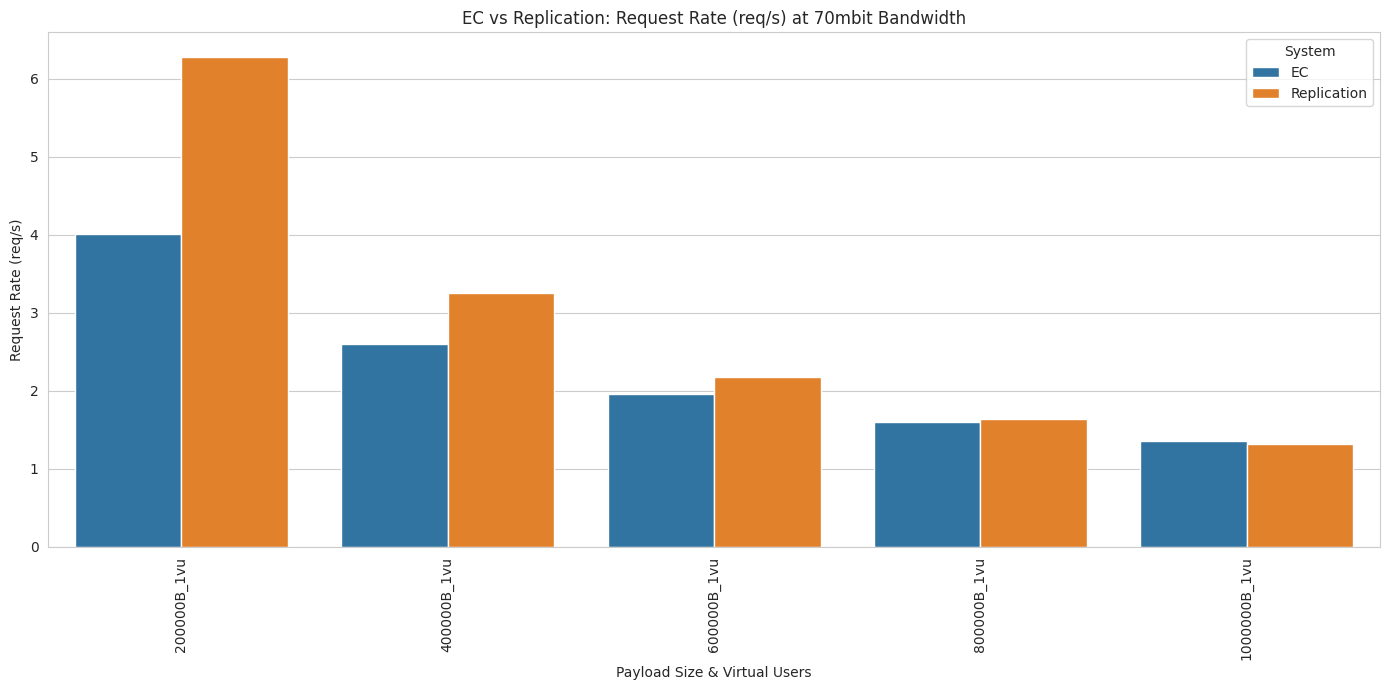

In [15]:
# 1. Grouping by bandwidth
# For each bandwidth, compare EC vs Replication across different payload sizes and virtual users
def plot_by_bandwidth(metric):
    # Sort bandwidths numerically using bandwidth_num
    bw_order = (
        df[['bandwidth', 'bandwidth_num']]
        .drop_duplicates()
        .sort_values('bandwidth_num')
        .bandwidth.tolist()
    )
    for bw in bw_order:
        # Filter data for this bandwidth
        df_bw = df[df['bandwidth'] == bw]
        
        if len(df_bw) > 0:
            plt.figure(figsize=(14, 7))
            # Create a new column for the x-axis that combines payload size and virtual users
            df_bw['payload_vu'] = df_bw.apply(lambda row: f"{row['payload_size']}B_{row['virtual_user']}vu", axis=1)
            
            # Plot
            sns.barplot(
                data=df_bw,
                x='payload_vu',
                y=metric,
                hue='system',
                ci=None,
                dodge=True
            )
            
            plt.title(f'EC vs Replication: {metric_titles[metric]} at {bw} Bandwidth')
            plt.xlabel('Payload Size & Virtual Users')
            plt.ylabel(metric_titles[metric])
            plt.xticks(rotation=90)
            plt.legend(title='System')
            plt.tight_layout()
            plt.show()

# Plot each metric grouped by bandwidth
for metric in metrics:
    plot_by_bandwidth(metric)

/tmp/ipykernel_3601799/2697771222.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = df_payload.apply(lambda row: f"{row['bandwidth']}_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/2697771222.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = pd.Categorical(df_payload['bw_vu'],
/tmp/ipykernel_3601799/2697771222.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


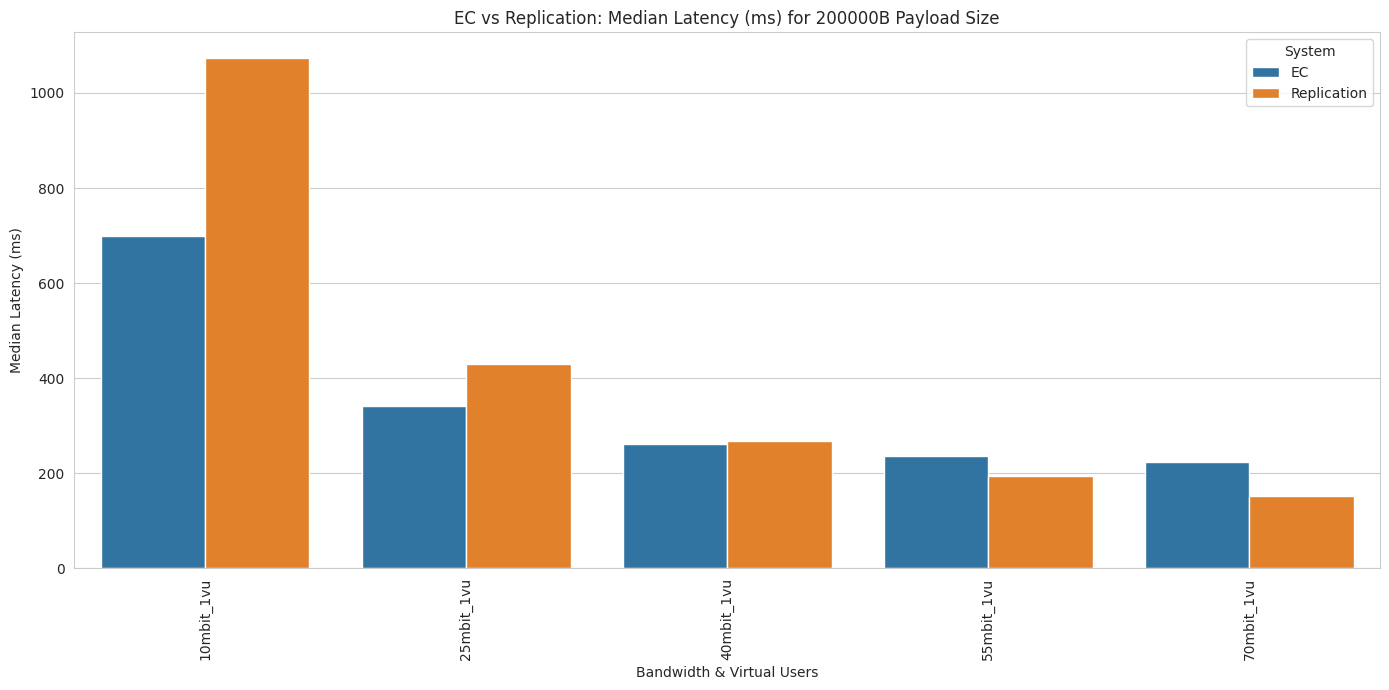

/tmp/ipykernel_3601799/2697771222.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = df_payload.apply(lambda row: f"{row['bandwidth']}_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/2697771222.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = pd.Categorical(df_payload['bw_vu'],
/tmp/ipykernel_3601799/2697771222.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


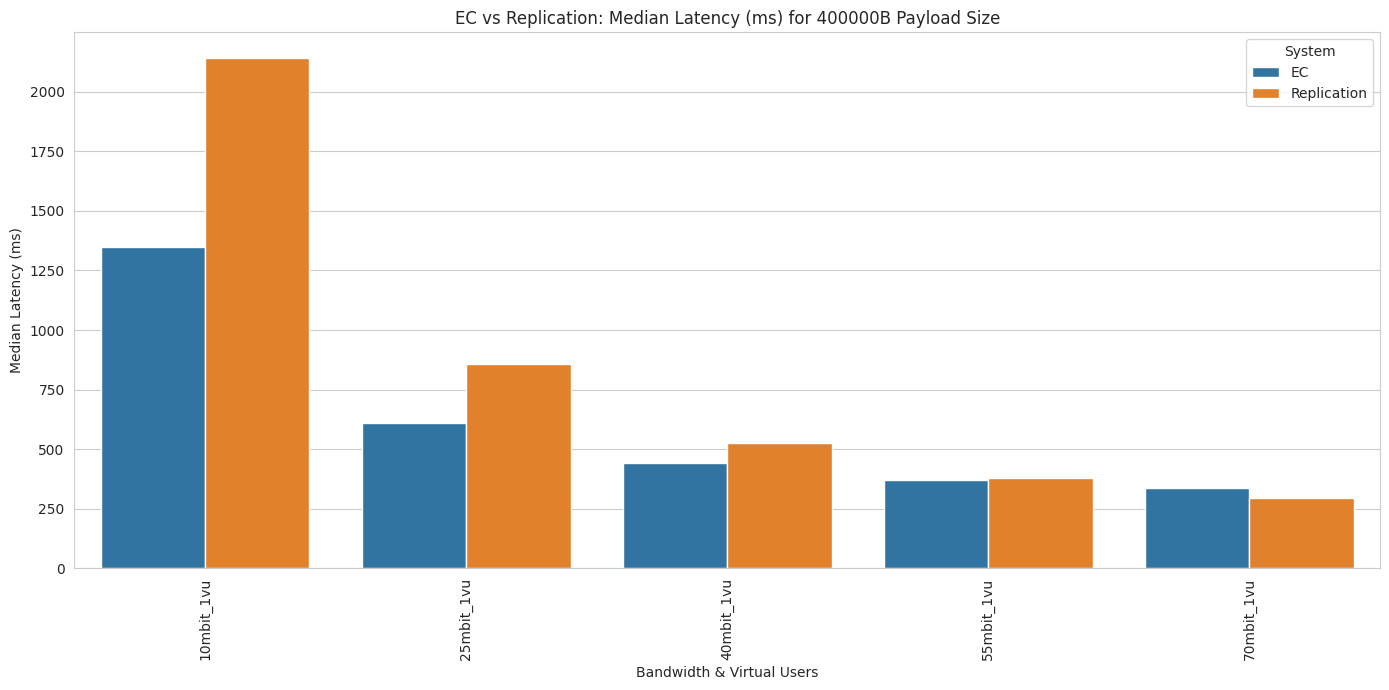

/tmp/ipykernel_3601799/2697771222.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = df_payload.apply(lambda row: f"{row['bandwidth']}_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/2697771222.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = pd.Categorical(df_payload['bw_vu'],
/tmp/ipykernel_3601799/2697771222.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


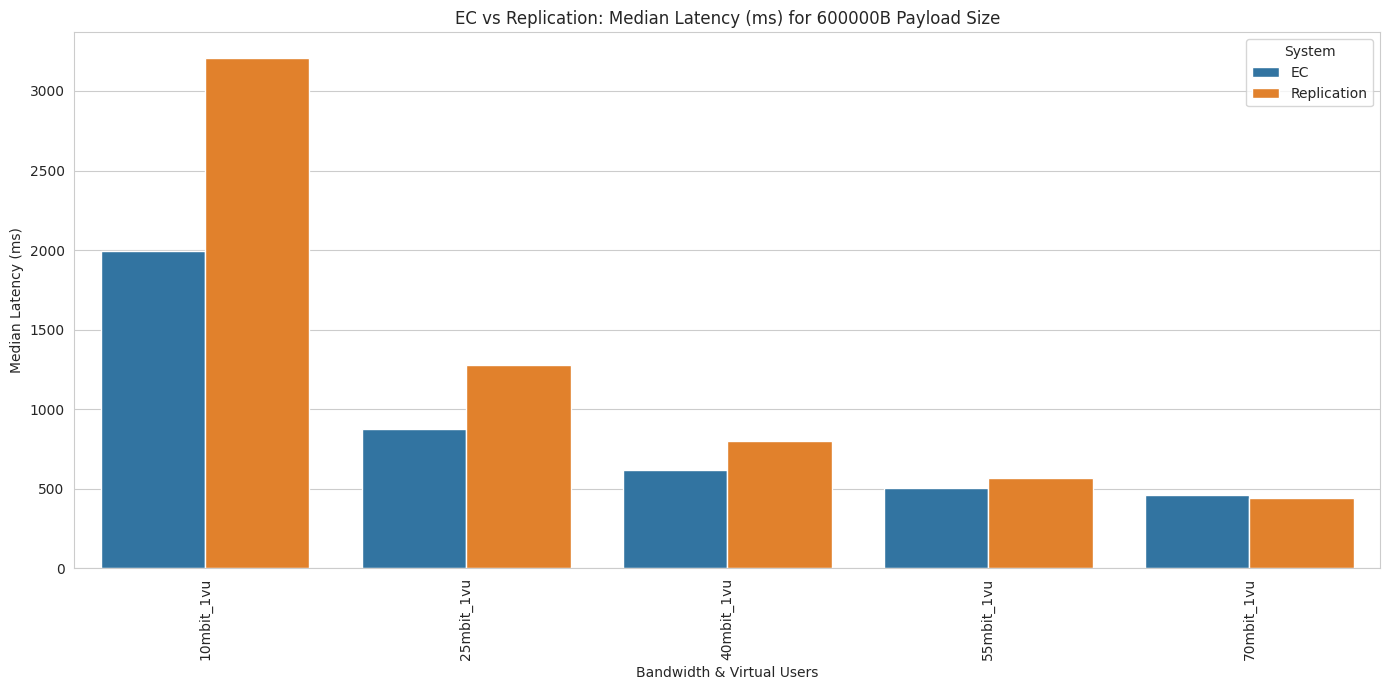

/tmp/ipykernel_3601799/2697771222.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = df_payload.apply(lambda row: f"{row['bandwidth']}_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/2697771222.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = pd.Categorical(df_payload['bw_vu'],
/tmp/ipykernel_3601799/2697771222.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


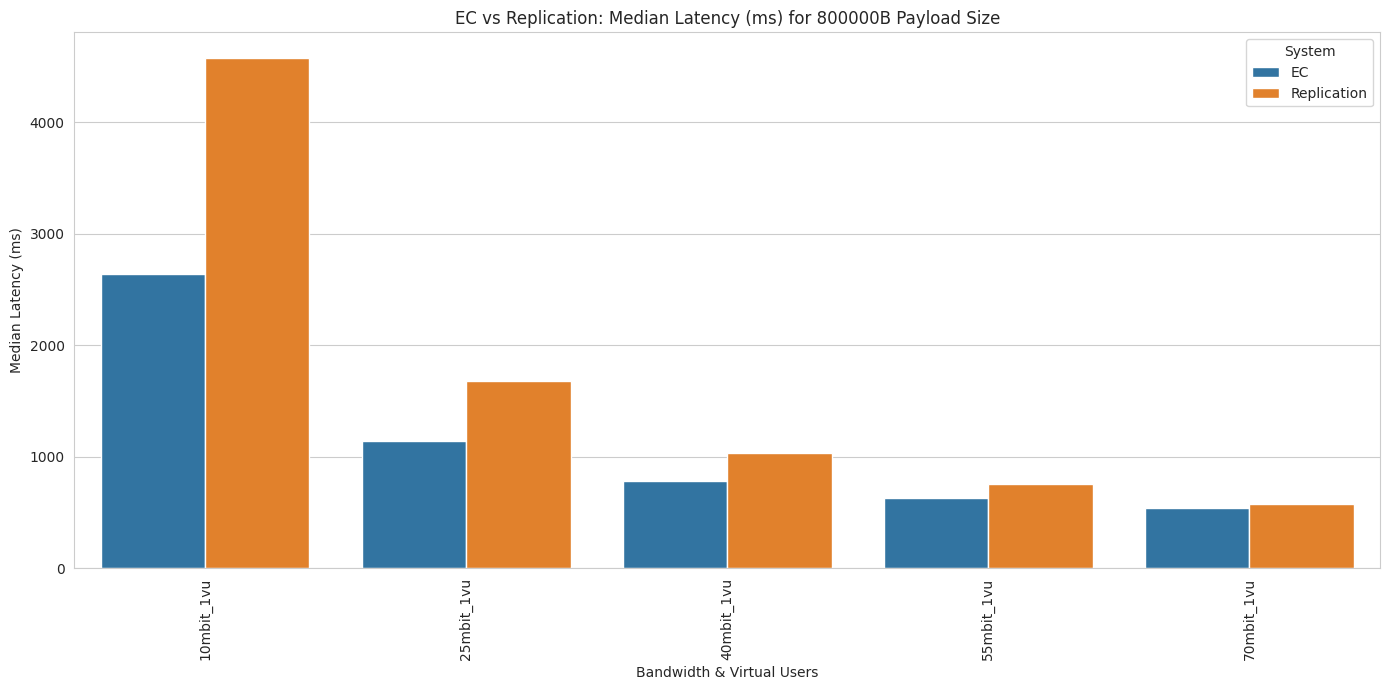

/tmp/ipykernel_3601799/2697771222.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = df_payload.apply(lambda row: f"{row['bandwidth']}_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/2697771222.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = pd.Categorical(df_payload['bw_vu'],
/tmp/ipykernel_3601799/2697771222.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


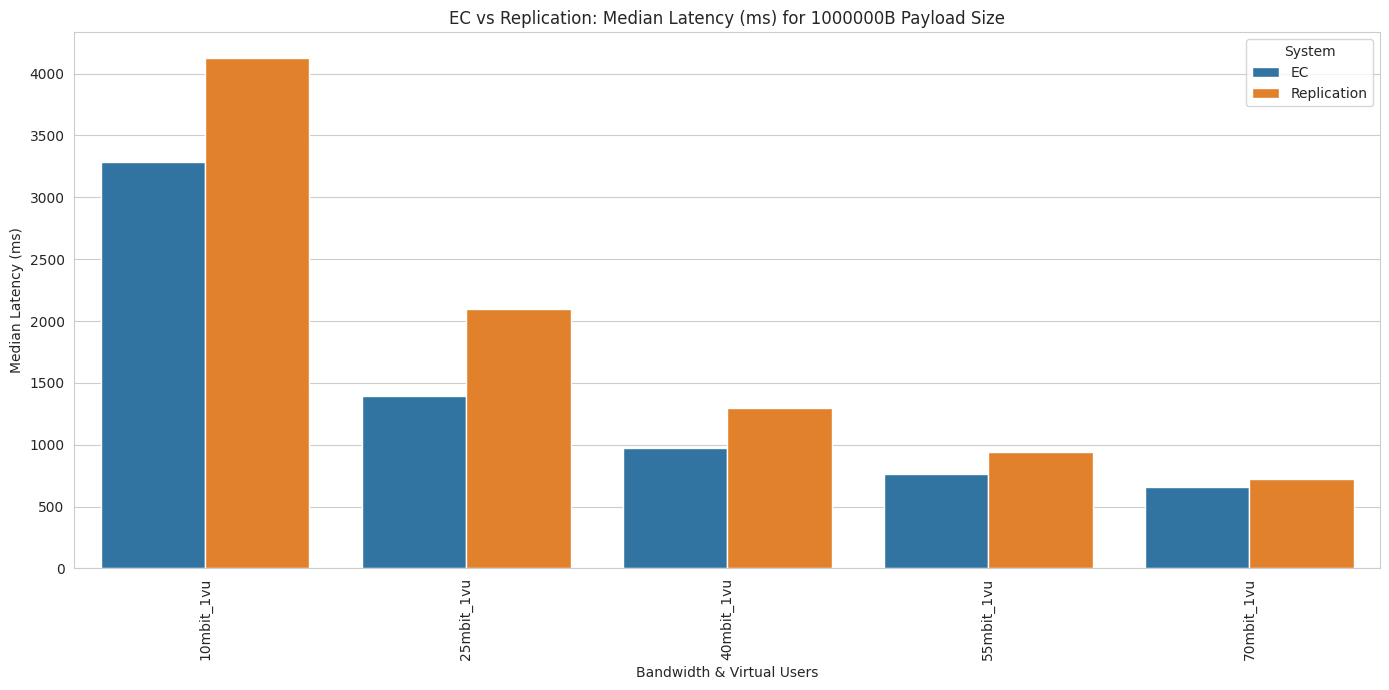

/tmp/ipykernel_3601799/2697771222.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = df_payload.apply(lambda row: f"{row['bandwidth']}_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/2697771222.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = pd.Categorical(df_payload['bw_vu'],
/tmp/ipykernel_3601799/2697771222.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


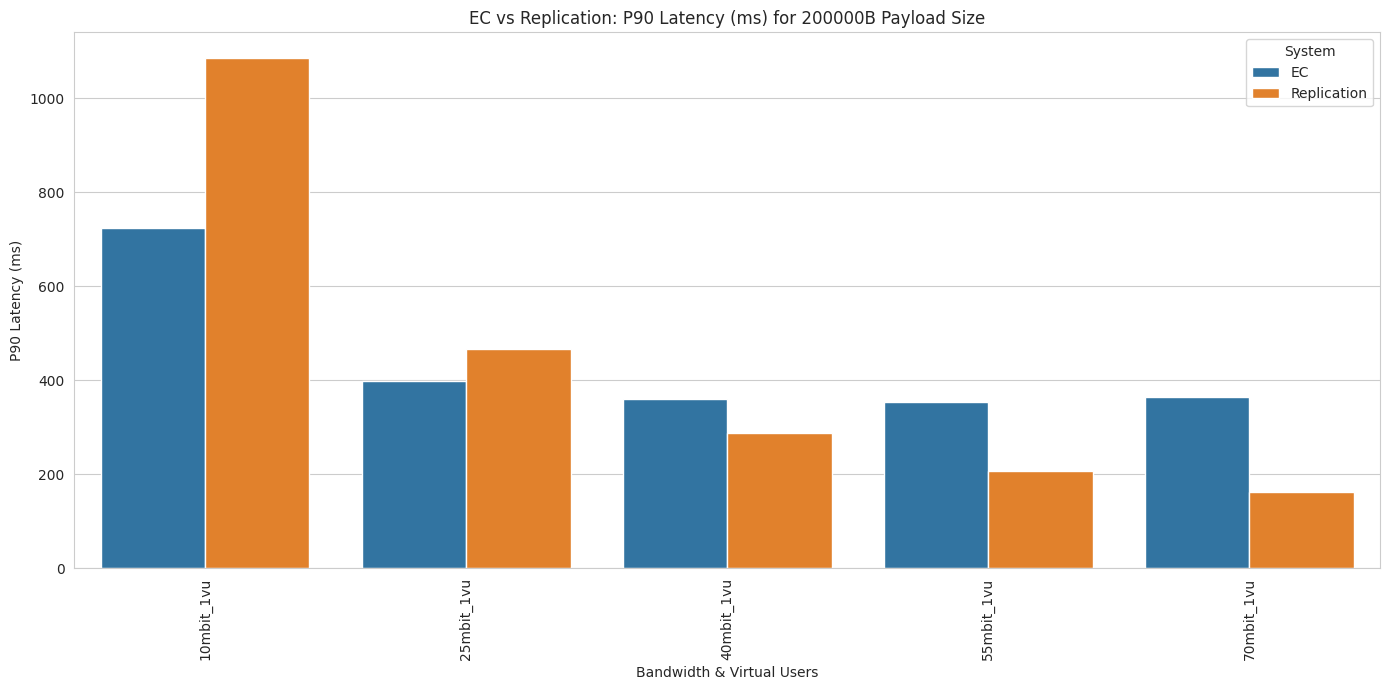

/tmp/ipykernel_3601799/2697771222.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = df_payload.apply(lambda row: f"{row['bandwidth']}_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/2697771222.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = pd.Categorical(df_payload['bw_vu'],
/tmp/ipykernel_3601799/2697771222.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


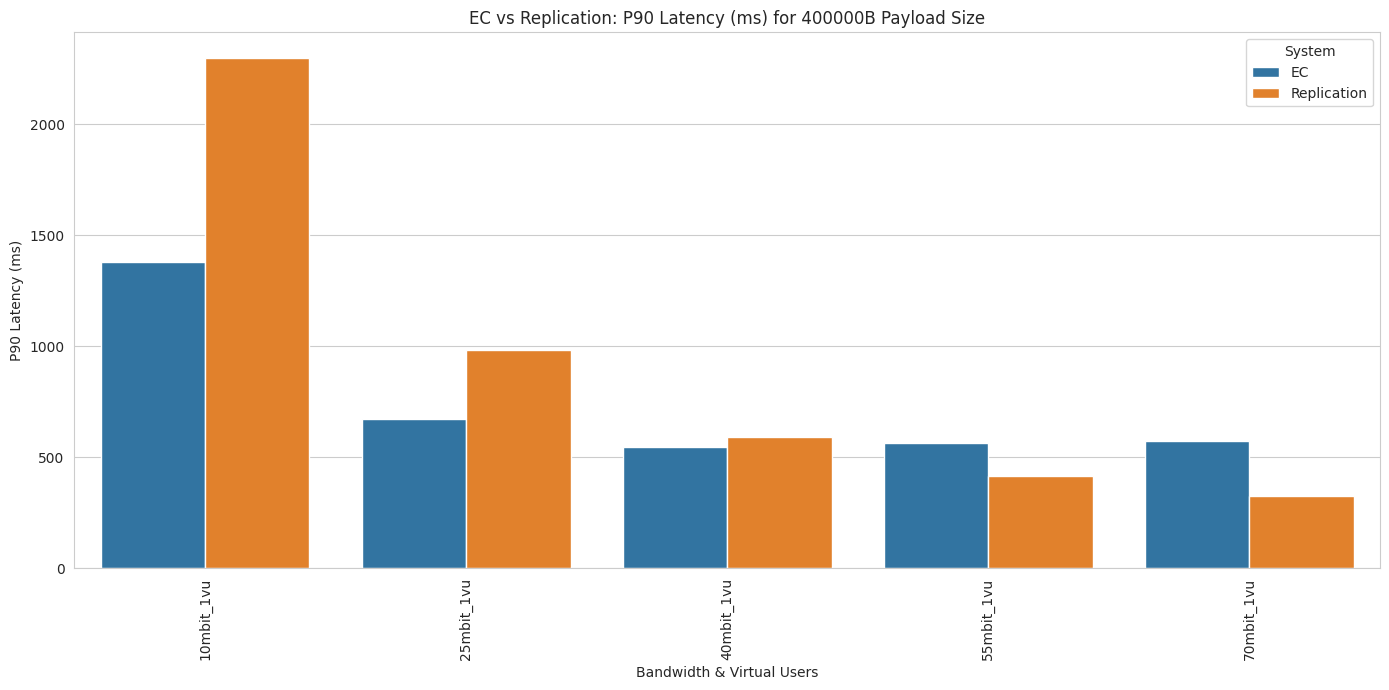

/tmp/ipykernel_3601799/2697771222.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = df_payload.apply(lambda row: f"{row['bandwidth']}_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/2697771222.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = pd.Categorical(df_payload['bw_vu'],
/tmp/ipykernel_3601799/2697771222.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


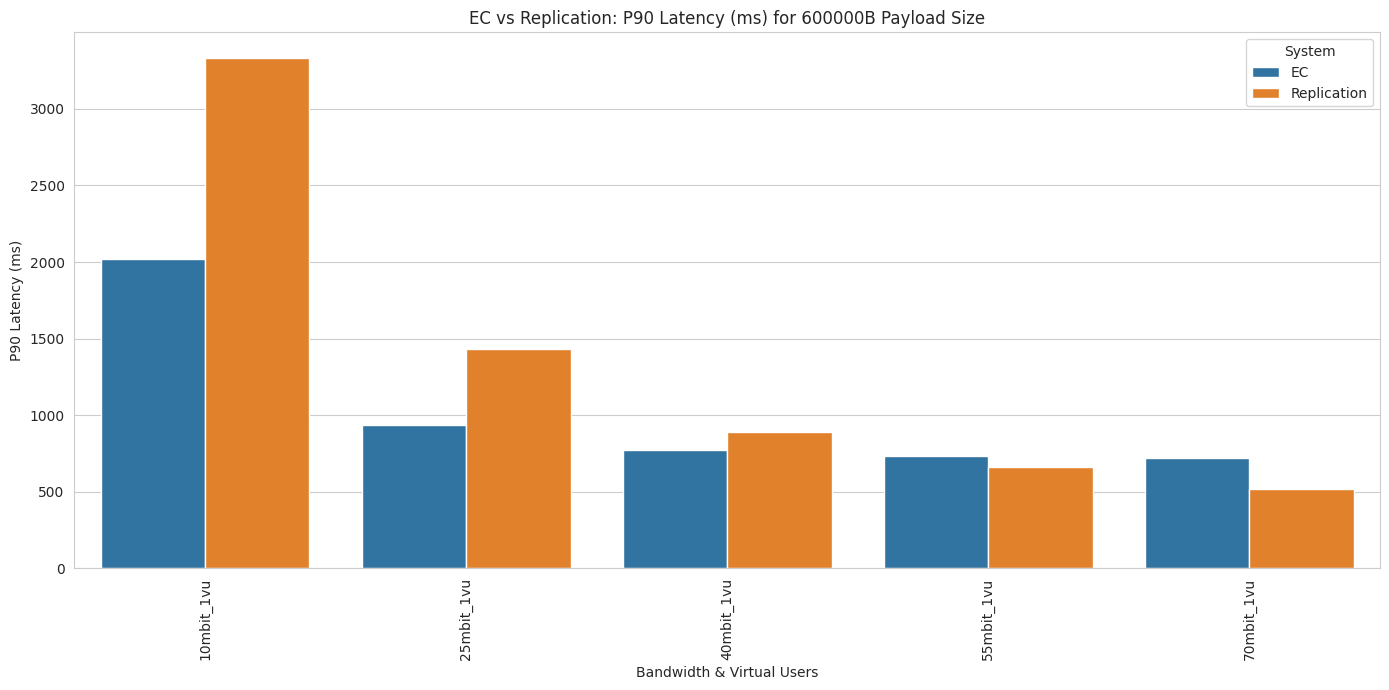

/tmp/ipykernel_3601799/2697771222.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = df_payload.apply(lambda row: f"{row['bandwidth']}_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/2697771222.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = pd.Categorical(df_payload['bw_vu'],
/tmp/ipykernel_3601799/2697771222.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


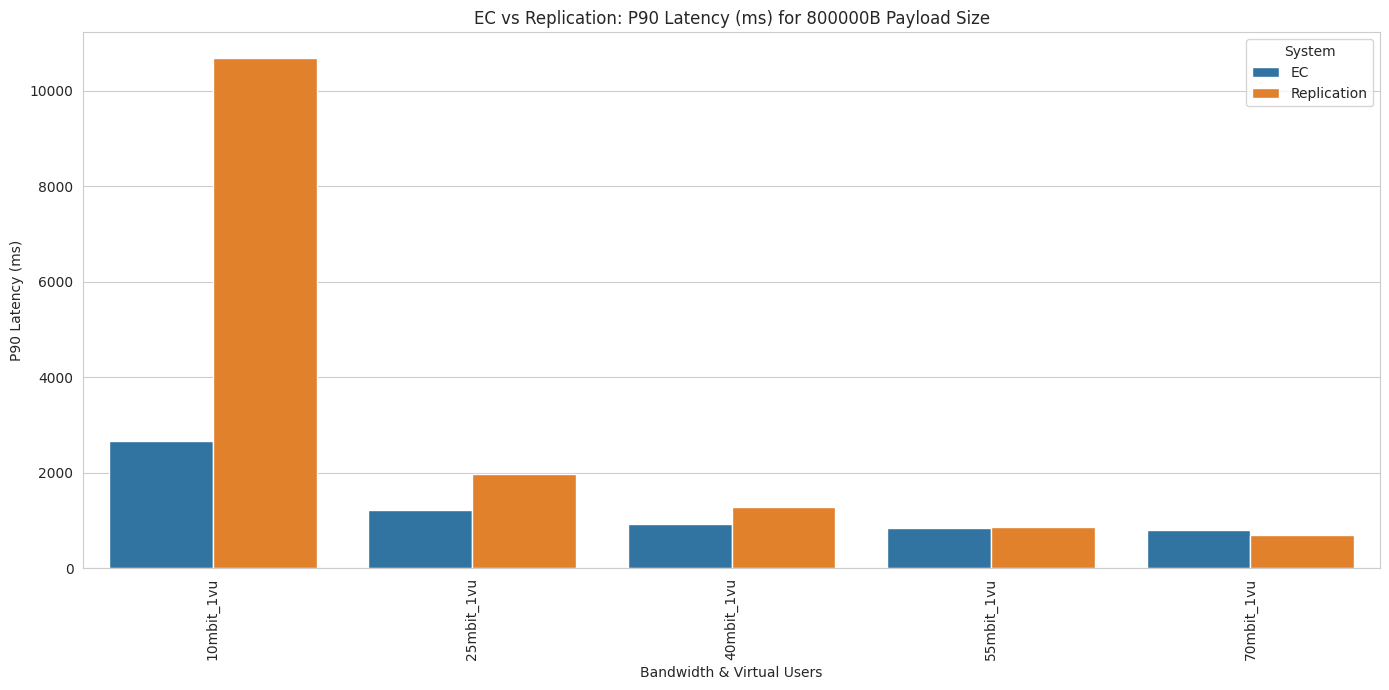

/tmp/ipykernel_3601799/2697771222.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = df_payload.apply(lambda row: f"{row['bandwidth']}_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/2697771222.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = pd.Categorical(df_payload['bw_vu'],
/tmp/ipykernel_3601799/2697771222.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


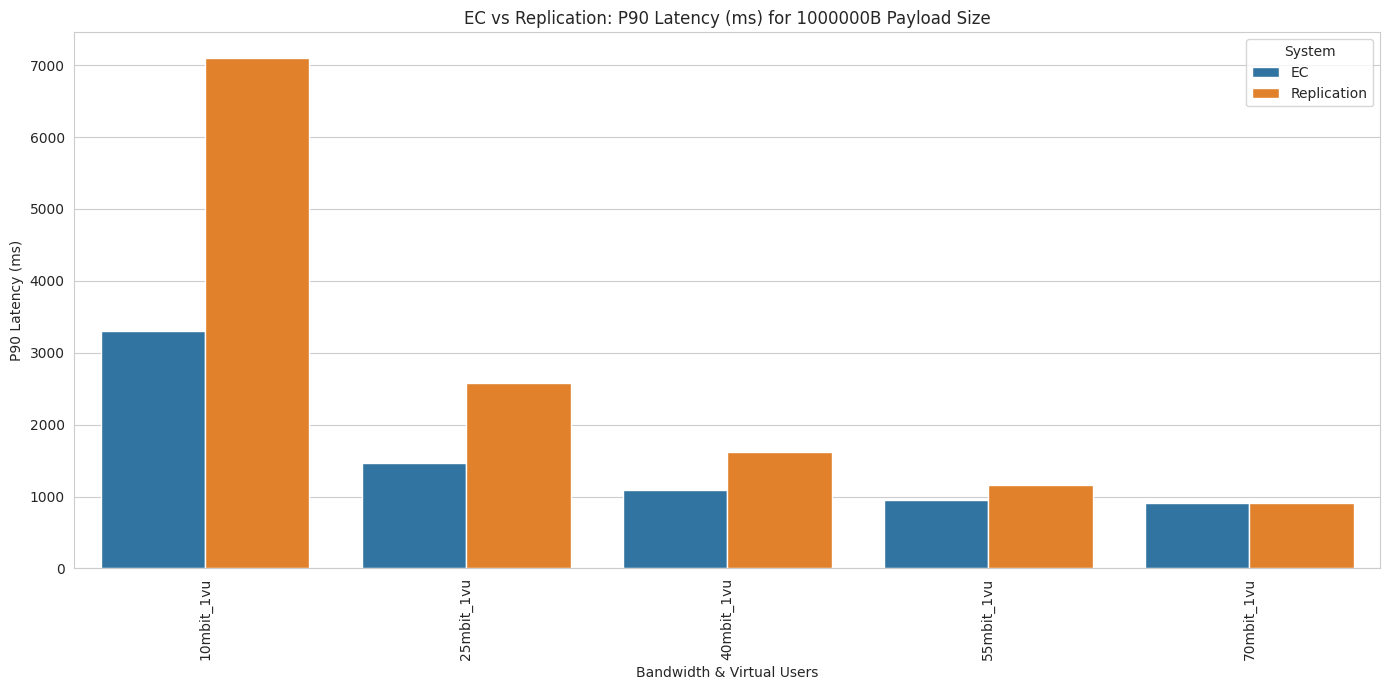

/tmp/ipykernel_3601799/2697771222.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = df_payload.apply(lambda row: f"{row['bandwidth']}_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/2697771222.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = pd.Categorical(df_payload['bw_vu'],
/tmp/ipykernel_3601799/2697771222.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


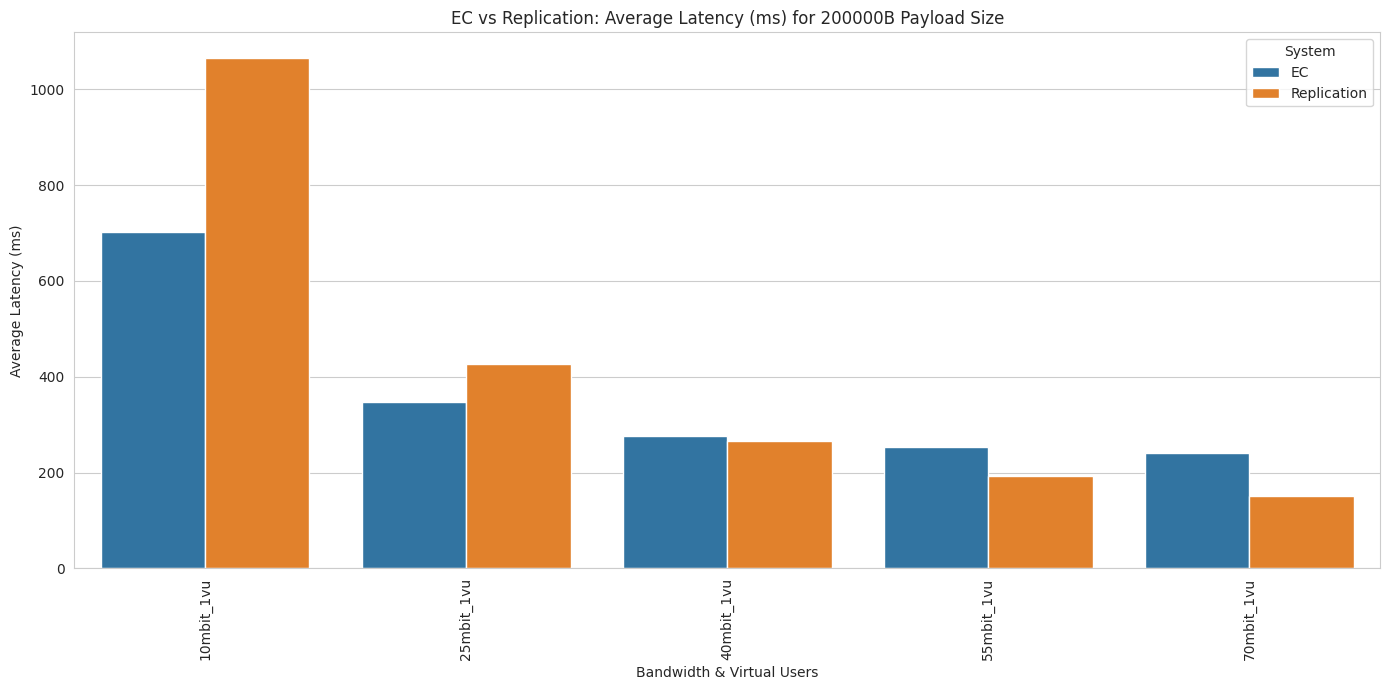

/tmp/ipykernel_3601799/2697771222.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = df_payload.apply(lambda row: f"{row['bandwidth']}_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/2697771222.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = pd.Categorical(df_payload['bw_vu'],
/tmp/ipykernel_3601799/2697771222.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


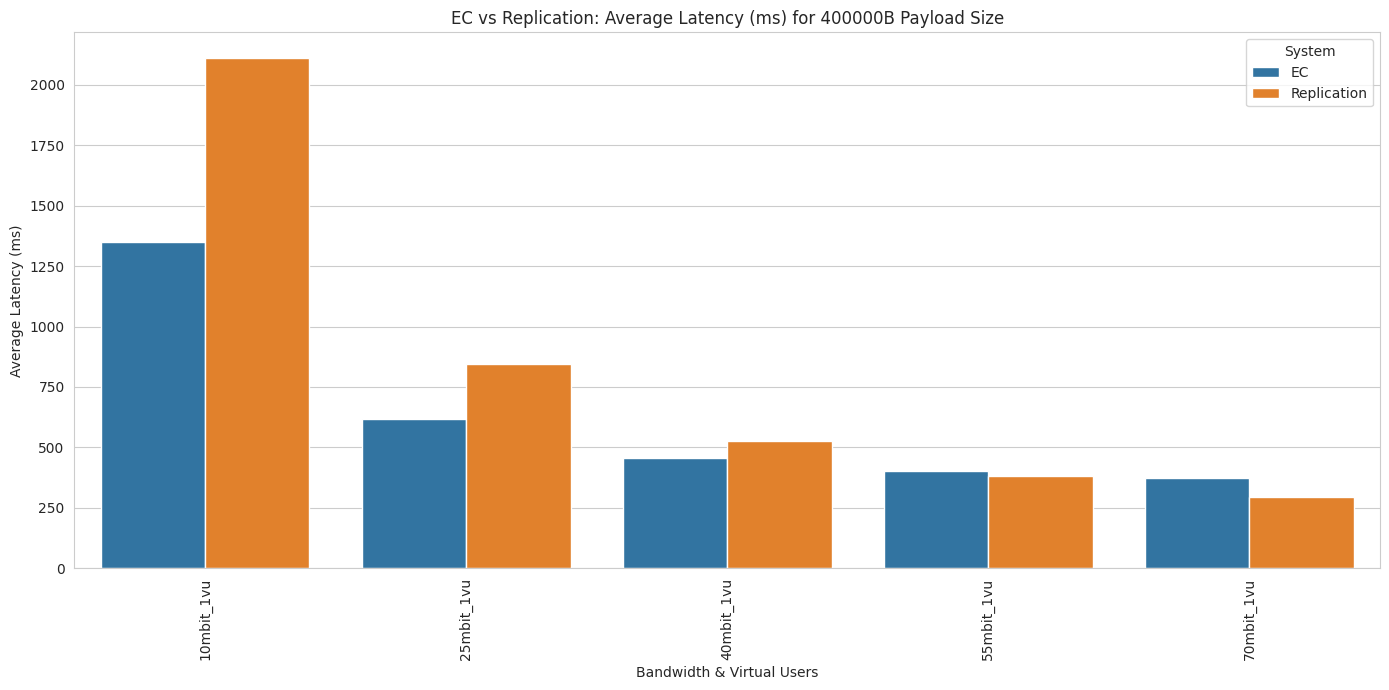

/tmp/ipykernel_3601799/2697771222.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = df_payload.apply(lambda row: f"{row['bandwidth']}_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/2697771222.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = pd.Categorical(df_payload['bw_vu'],
/tmp/ipykernel_3601799/2697771222.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


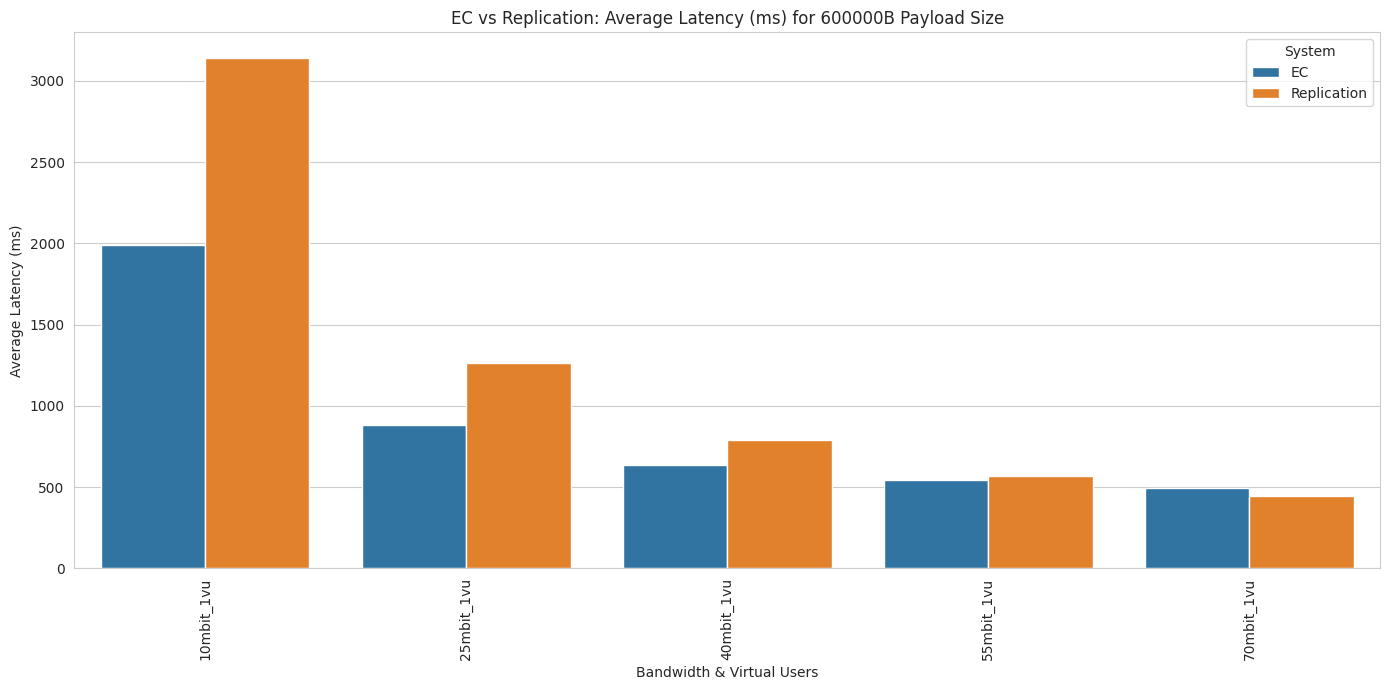

/tmp/ipykernel_3601799/2697771222.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = df_payload.apply(lambda row: f"{row['bandwidth']}_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/2697771222.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = pd.Categorical(df_payload['bw_vu'],
/tmp/ipykernel_3601799/2697771222.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


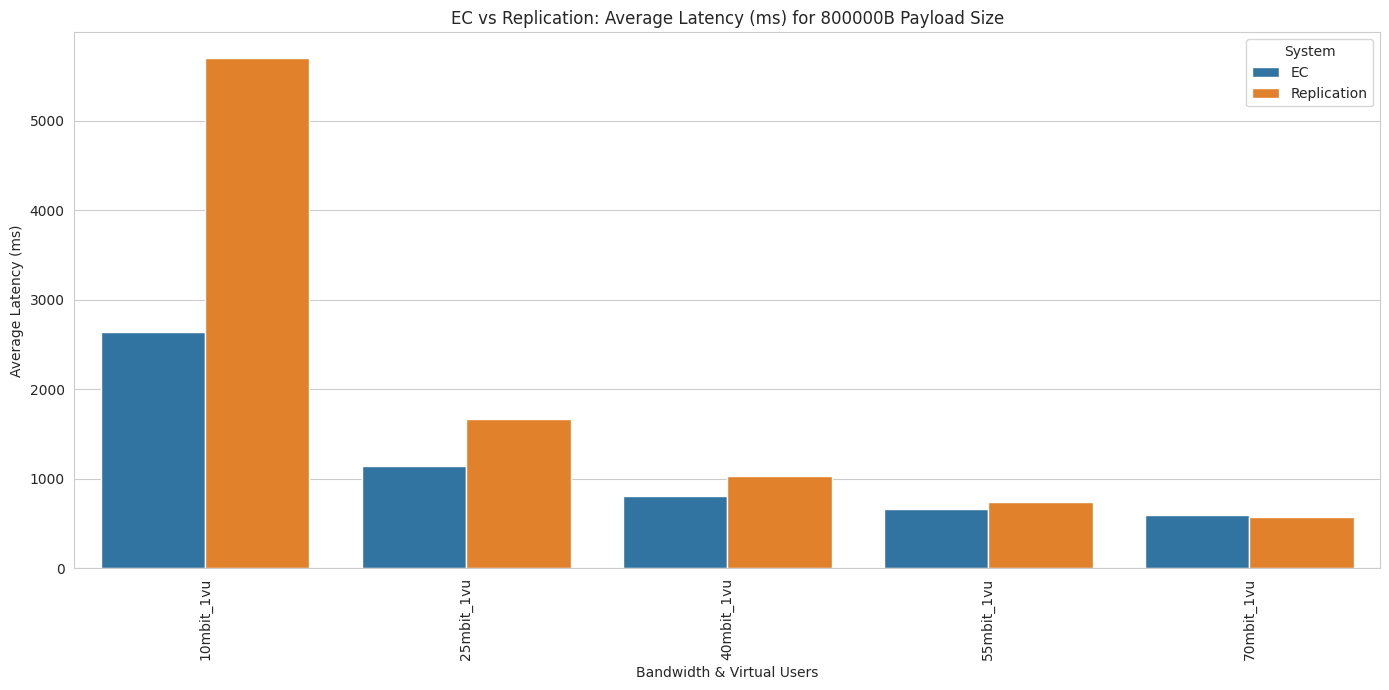

/tmp/ipykernel_3601799/2697771222.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = df_payload.apply(lambda row: f"{row['bandwidth']}_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/2697771222.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = pd.Categorical(df_payload['bw_vu'],
/tmp/ipykernel_3601799/2697771222.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


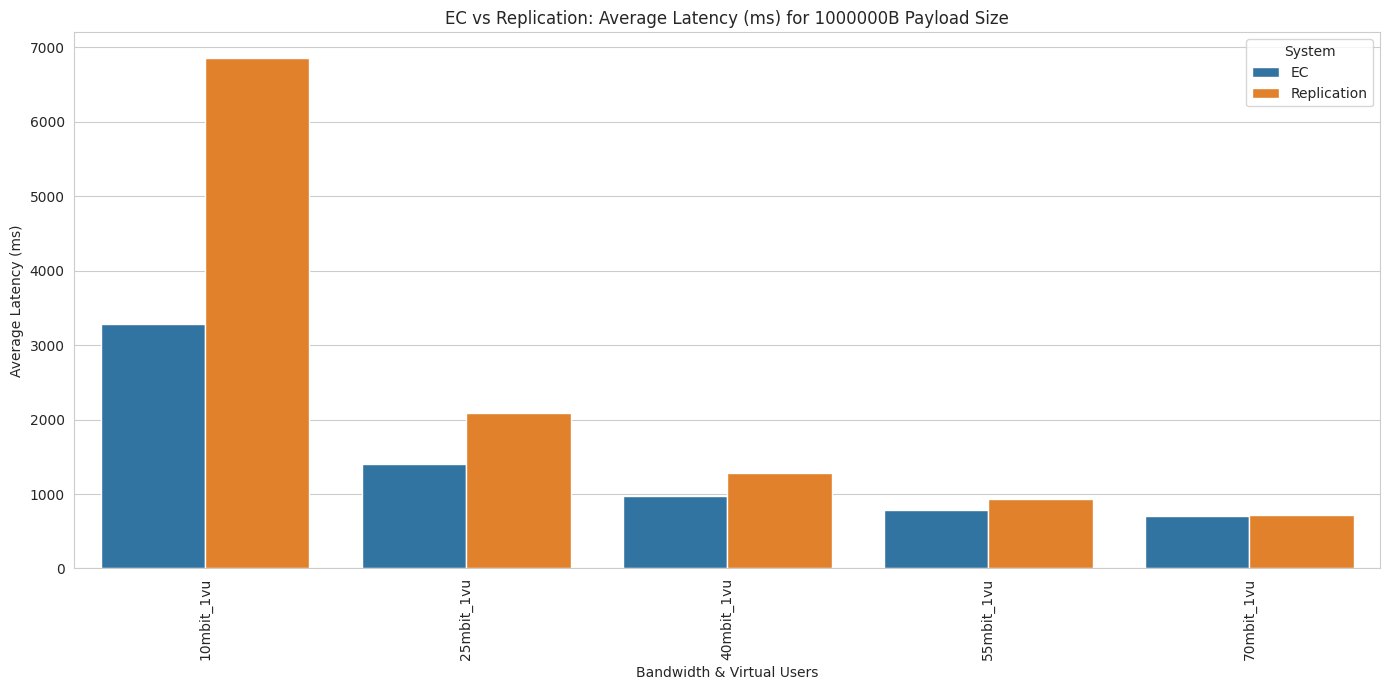

/tmp/ipykernel_3601799/2697771222.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = df_payload.apply(lambda row: f"{row['bandwidth']}_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/2697771222.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = pd.Categorical(df_payload['bw_vu'],
/tmp/ipykernel_3601799/2697771222.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


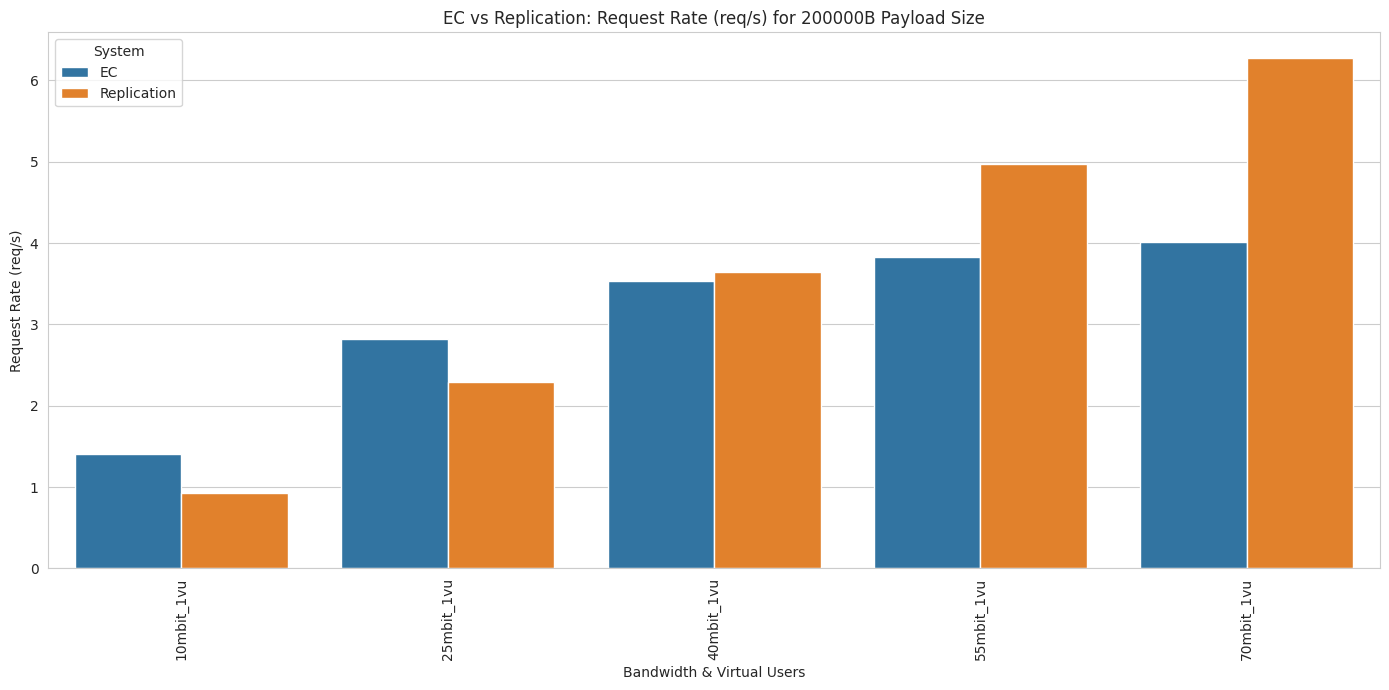

/tmp/ipykernel_3601799/2697771222.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = df_payload.apply(lambda row: f"{row['bandwidth']}_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/2697771222.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = pd.Categorical(df_payload['bw_vu'],
/tmp/ipykernel_3601799/2697771222.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


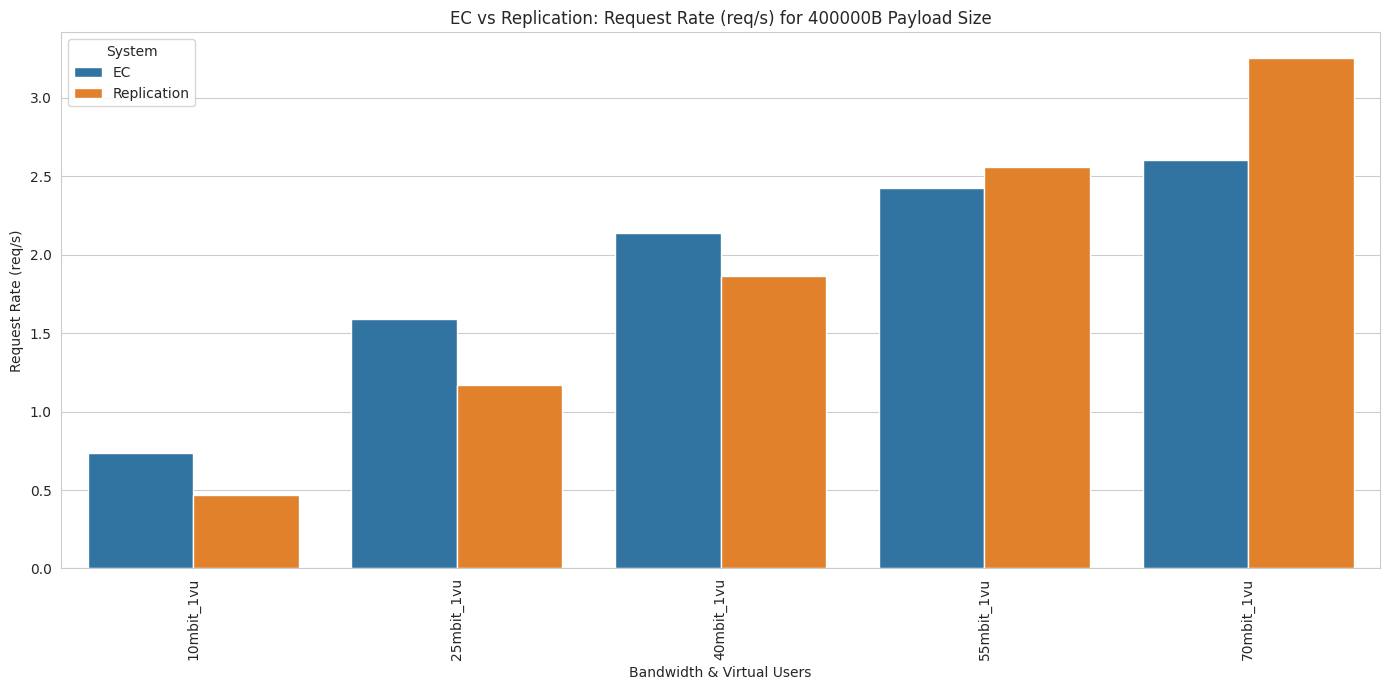

/tmp/ipykernel_3601799/2697771222.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = df_payload.apply(lambda row: f"{row['bandwidth']}_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/2697771222.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = pd.Categorical(df_payload['bw_vu'],
/tmp/ipykernel_3601799/2697771222.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


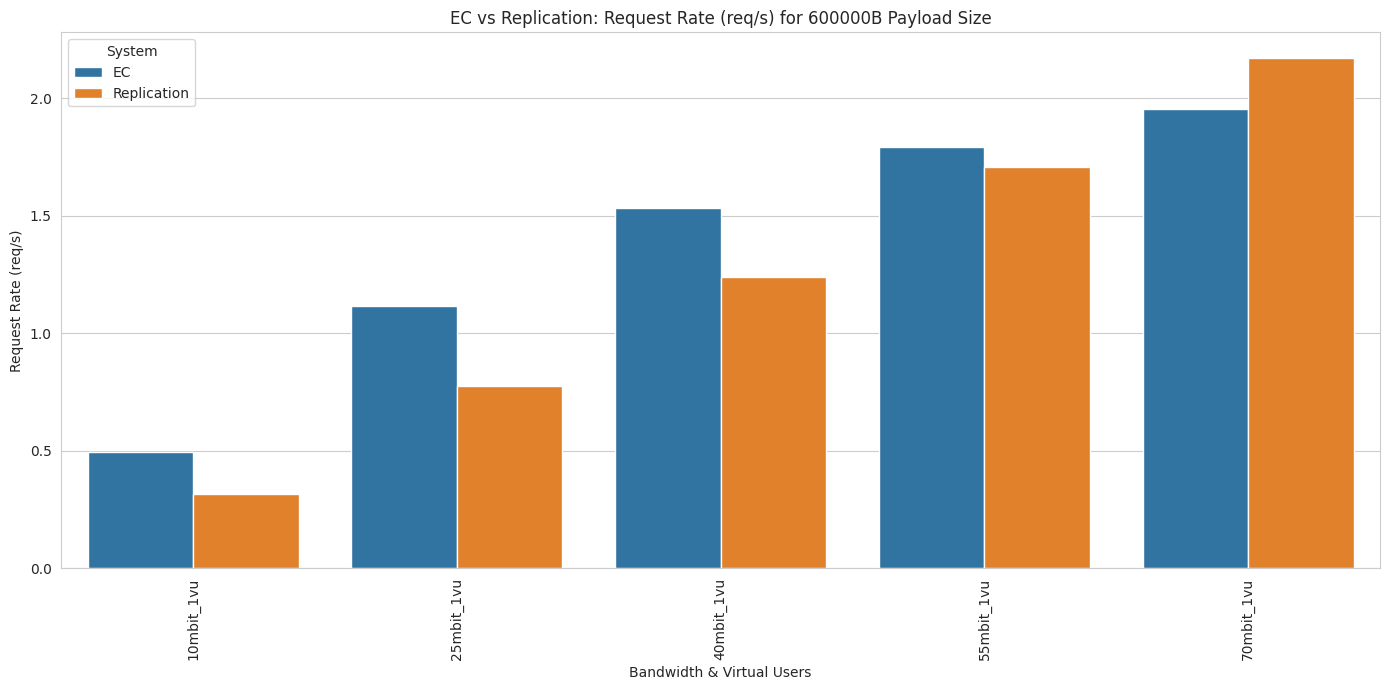

/tmp/ipykernel_3601799/2697771222.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = df_payload.apply(lambda row: f"{row['bandwidth']}_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/2697771222.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = pd.Categorical(df_payload['bw_vu'],
/tmp/ipykernel_3601799/2697771222.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


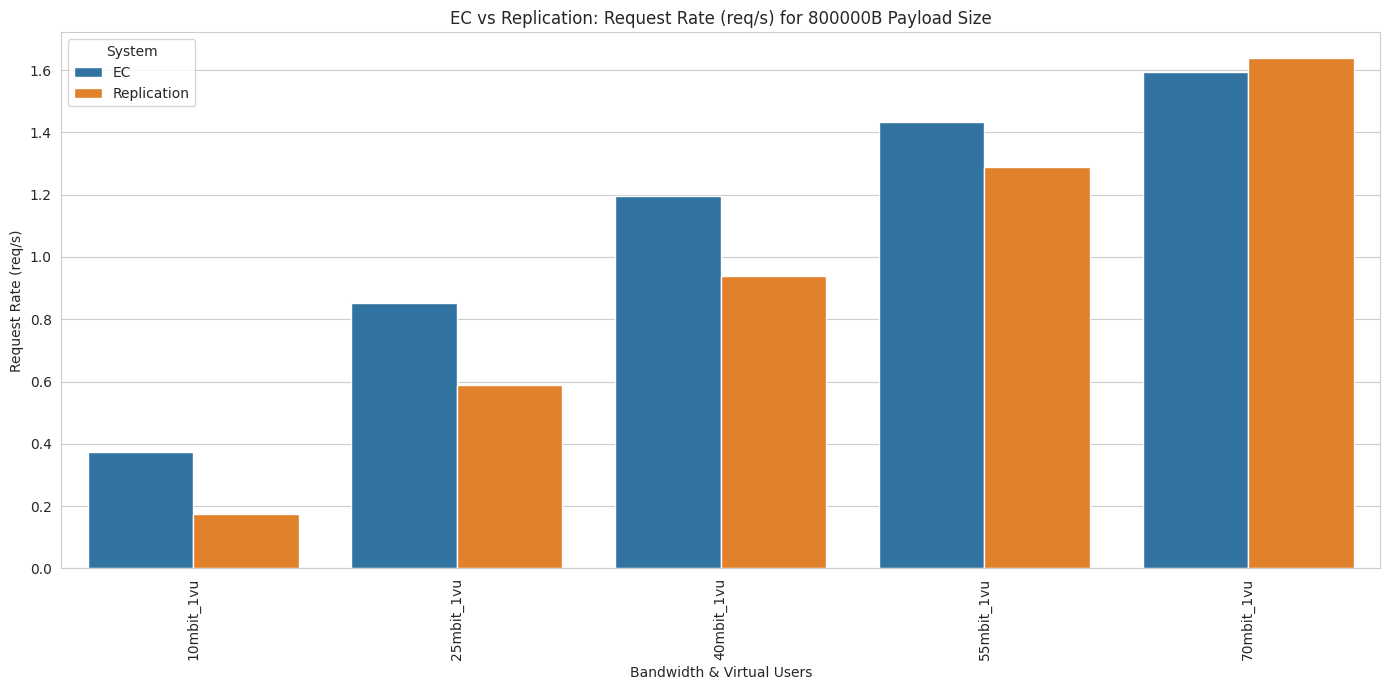

/tmp/ipykernel_3601799/2697771222.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = df_payload.apply(lambda row: f"{row['bandwidth']}_{row['virtual_user']}vu", axis=1)
/tmp/ipykernel_3601799/2697771222.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_payload['bw_vu'] = pd.Categorical(df_payload['bw_vu'],
/tmp/ipykernel_3601799/2697771222.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


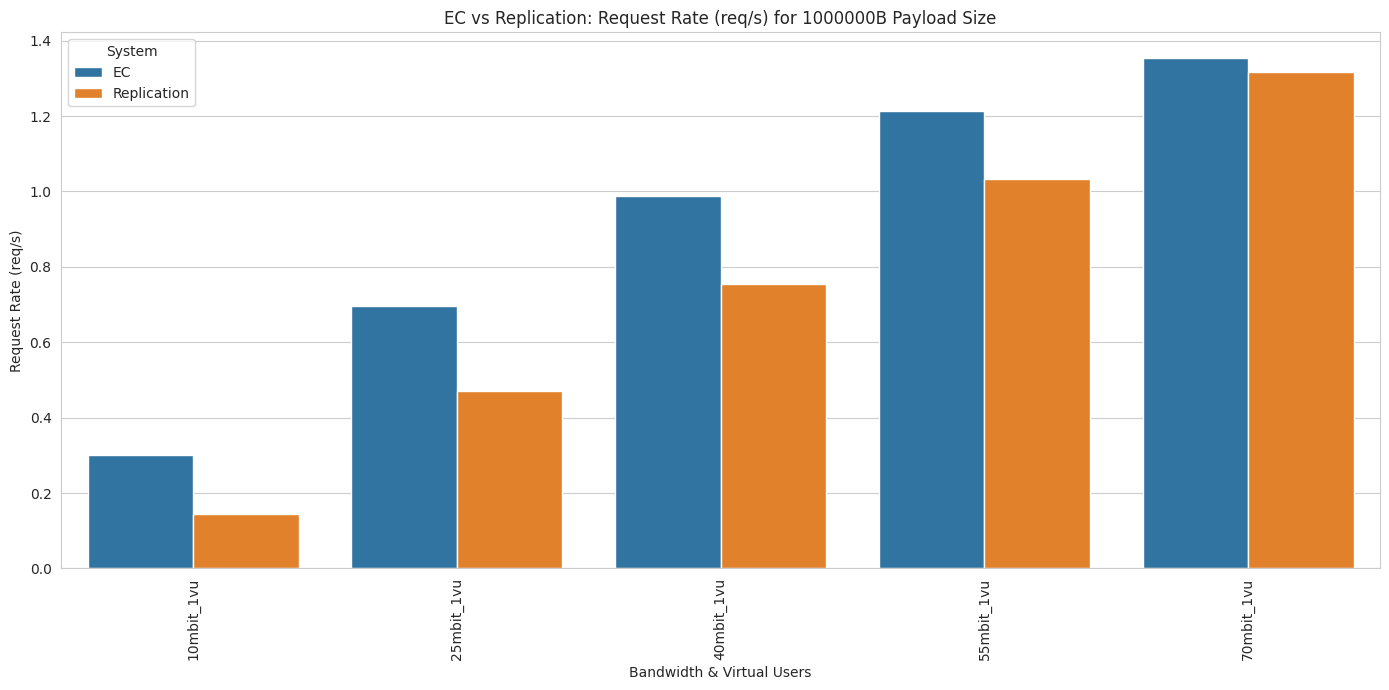

In [16]:
# 2. Grouping by payload size
# For each payload size, compare EC vs Replication across different bandwidths and virtual users
def plot_by_payload(metric):
    payloads = df['payload_size'].unique()
    for payload in payloads:
        # Filter data for this payload size
        df_payload = df[df['payload_size'] == payload]
        
        if len(df_payload) > 0:
            plt.figure(figsize=(14, 7))
            # Sort bandwidths numerically for this payload
            bw_order = (
                df_payload[['bandwidth', 'bandwidth_num']]
                .drop_duplicates()
                .sort_values('bandwidth_num')
                .bandwidth.tolist()
            )
            # Create a new column for the x-axis that combines bandwidth and virtual users
            df_payload['bw_vu'] = df_payload.apply(lambda row: f"{row['bandwidth']}_{row['virtual_user']}vu", axis=1)
            # Sort x-axis by bandwidth order then virtual user
            df_payload['bw_vu'] = pd.Categorical(df_payload['bw_vu'],
                [f"{bw}_{vu}vu" for bw in bw_order for vu in sorted(df_payload['virtual_user'].unique())],
                ordered=True)
            # Plot
            sns.barplot(
                data=df_payload,
                x='bw_vu',
                y=metric,
                hue='system',
                ci=None,
                dodge=True
            )
            
            plt.title(f'EC vs Replication: {metric_titles[metric]} for {payload}B Payload Size')
            plt.xlabel('Bandwidth & Virtual Users')
            plt.ylabel(metric_titles[metric])
            plt.xticks(rotation=90)
            plt.legend(title='System')
            plt.tight_layout()
            plt.show()

# Plot each metric grouped by payload size
for metric in metrics:
    plot_by_payload(metric)

/tmp/ipykernel_3601799/528289815.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


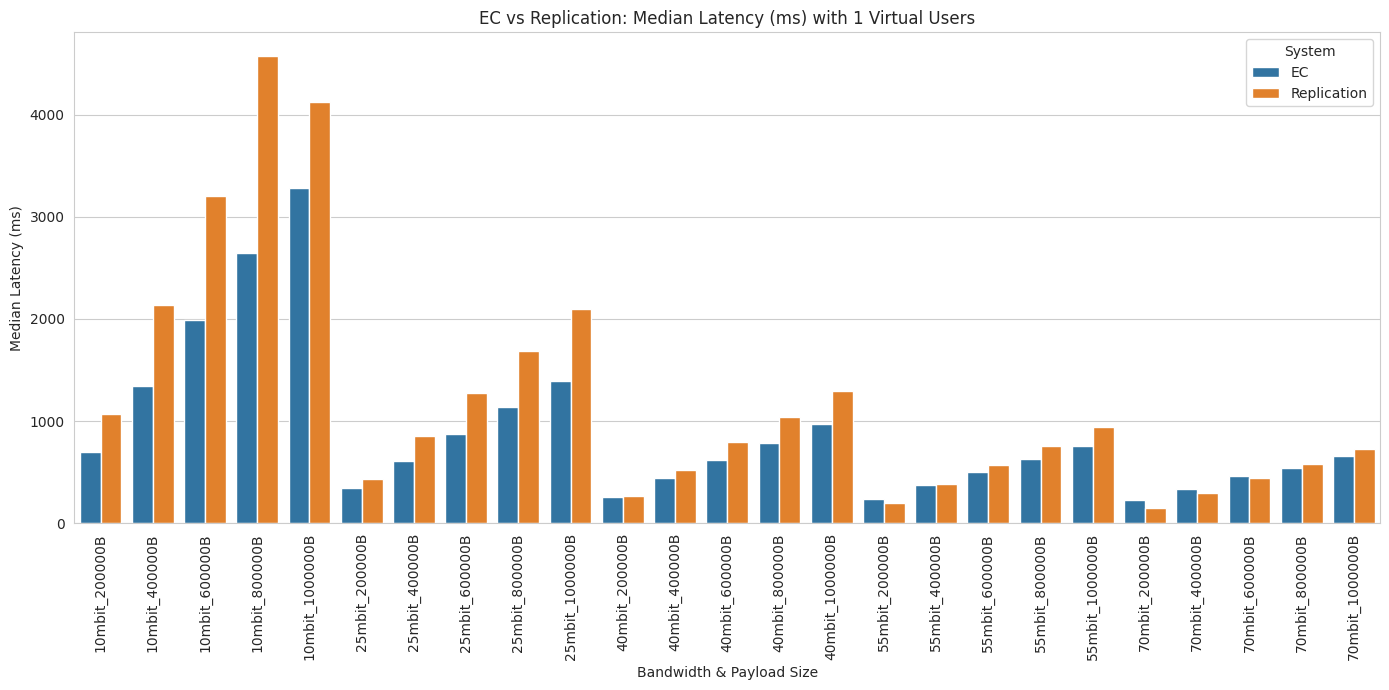

/tmp/ipykernel_3601799/528289815.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


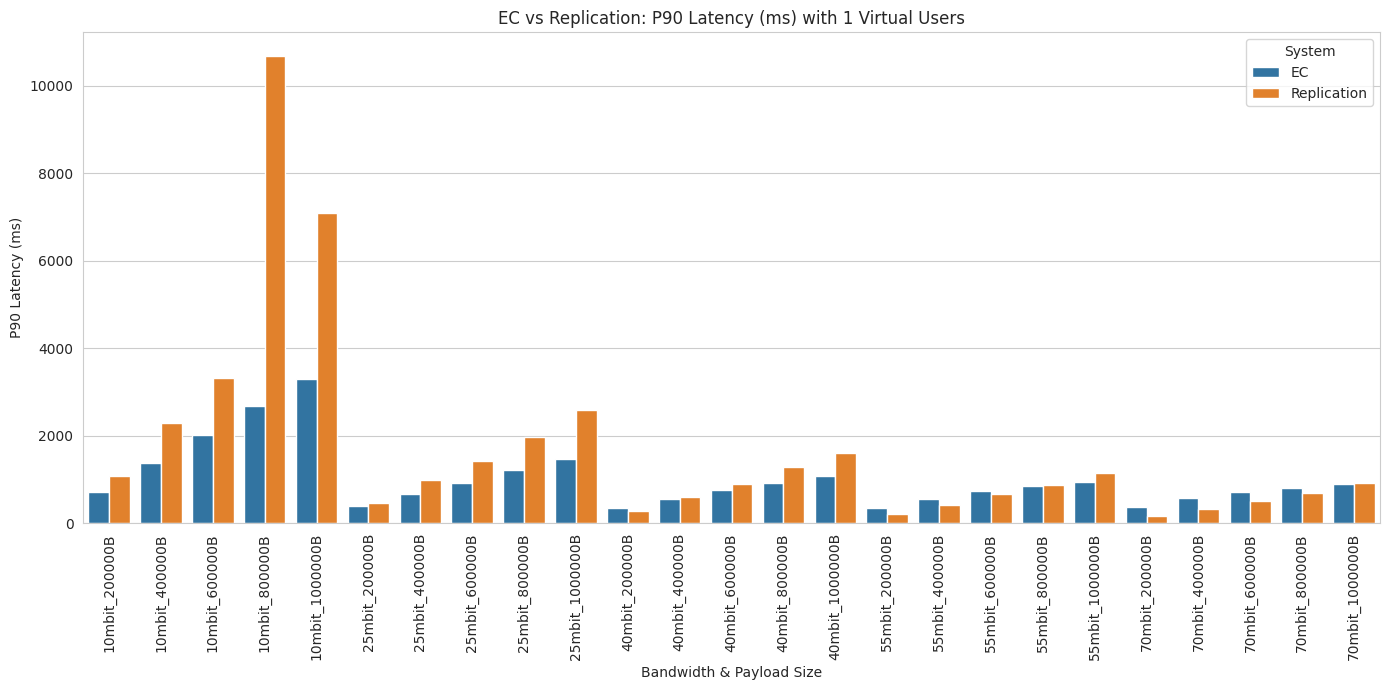

/tmp/ipykernel_3601799/528289815.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


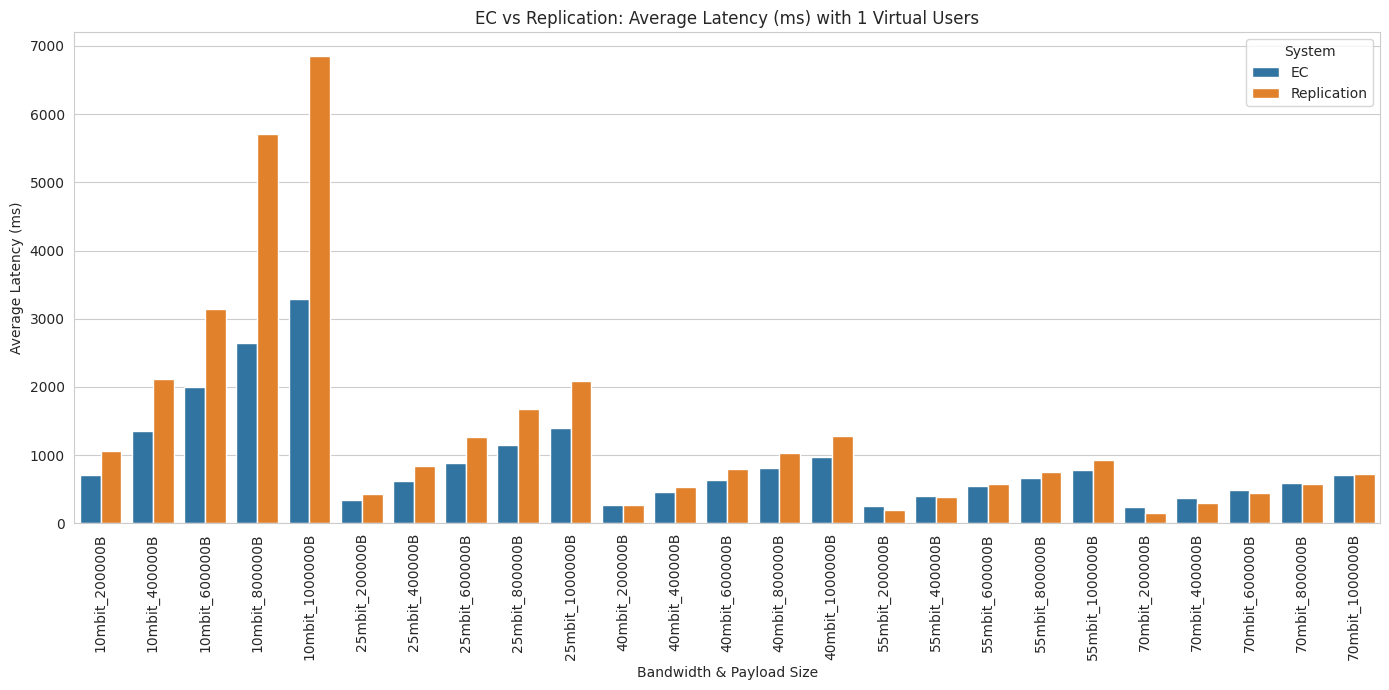

/tmp/ipykernel_3601799/528289815.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


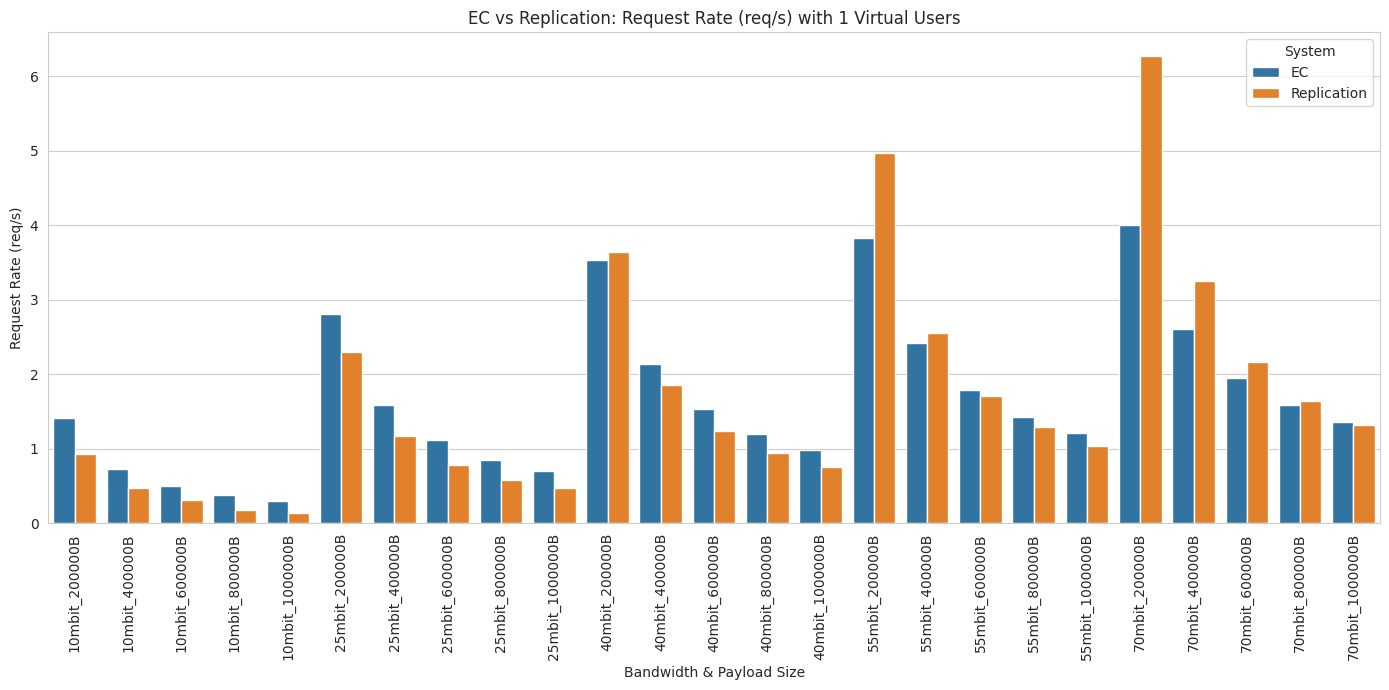

In [17]:
# 3. Grouping by virtual users
# For each virtual user count, compare EC vs Replication across different bandwidths and payload sizes
def plot_by_vu(metric):
    vus = df['virtual_user'].unique()
    for vu in vus:
        # Filter data for this virtual user count
        df_vu = df[df['virtual_user'] == vu]
        
        if len(df_vu) > 0:
            plt.figure(figsize=(14, 7))
            # Sort bandwidths numerically for this vu
            bw_order = (
                df_vu[['bandwidth', 'bandwidth_num']]
                .drop_duplicates()
                .sort_values('bandwidth_num')
                .bandwidth.tolist()
            )
            # Create a new column for the x-axis that combines bandwidth and payload size
            df_vu['bw_payload'] = df_vu.apply(lambda row: f"{row['bandwidth']}_{row['payload_size']}B", axis=1)
            # Sort x-axis by bandwidth order then payload size
            df_vu['bw_payload'] = pd.Categorical(df_vu['bw_payload'],
                [f"{bw}_{ps}B" for bw in bw_order for ps in sorted(df_vu['payload_size'].unique())],
                ordered=True)
            # Plot
            sns.barplot(
                data=df_vu,
                x='bw_payload',
                y=metric,
                hue='system',
                ci=None,
                dodge=True
            )
            
            plt.title(f'EC vs Replication: {metric_titles[metric]} with {vu} Virtual Users')
            plt.xlabel('Bandwidth & Payload Size')
            plt.ylabel(metric_titles[metric])
            plt.xticks(rotation=90)
            plt.legend(title='System')
            plt.tight_layout()
            plt.show()

# Plot each metric grouped by virtual users
for metric in metrics:
    plot_by_vu(metric)

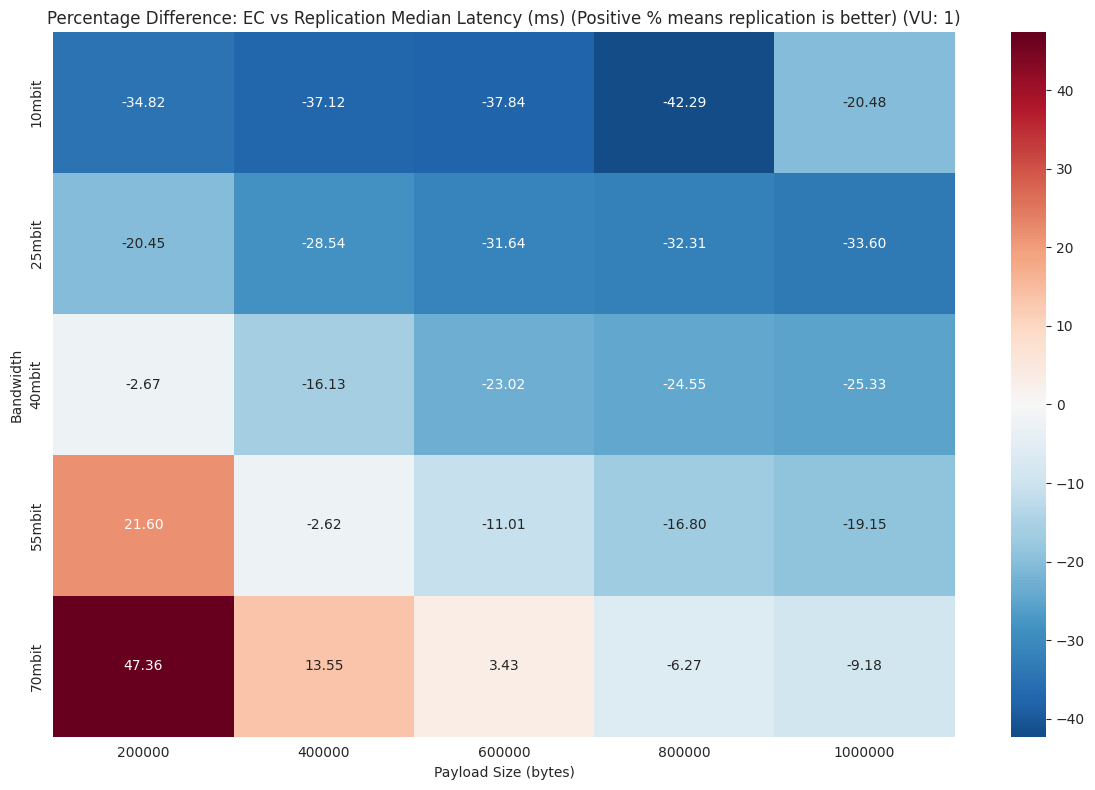

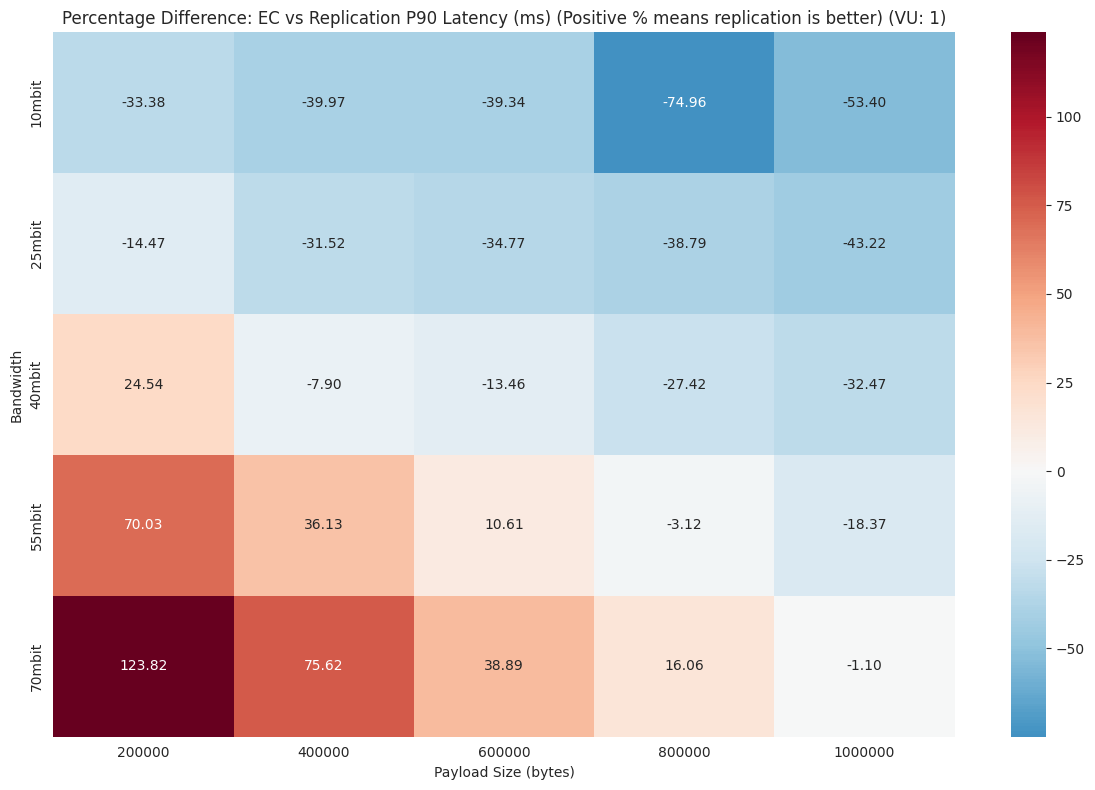

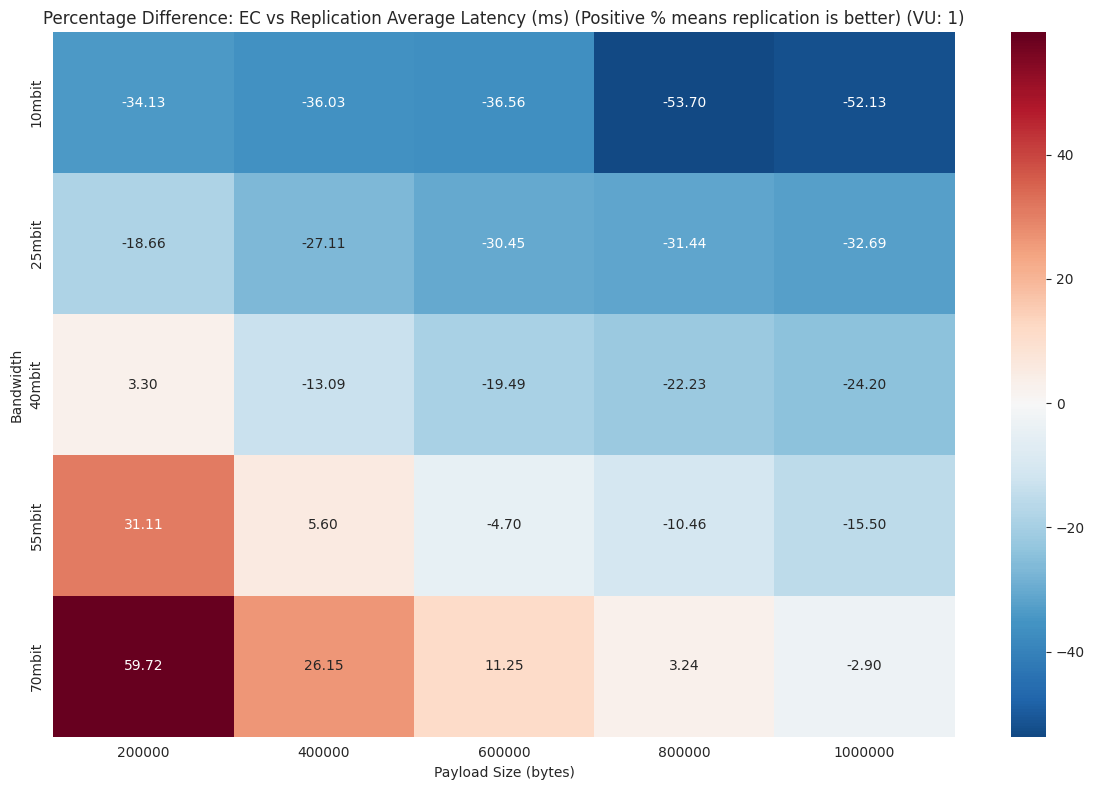

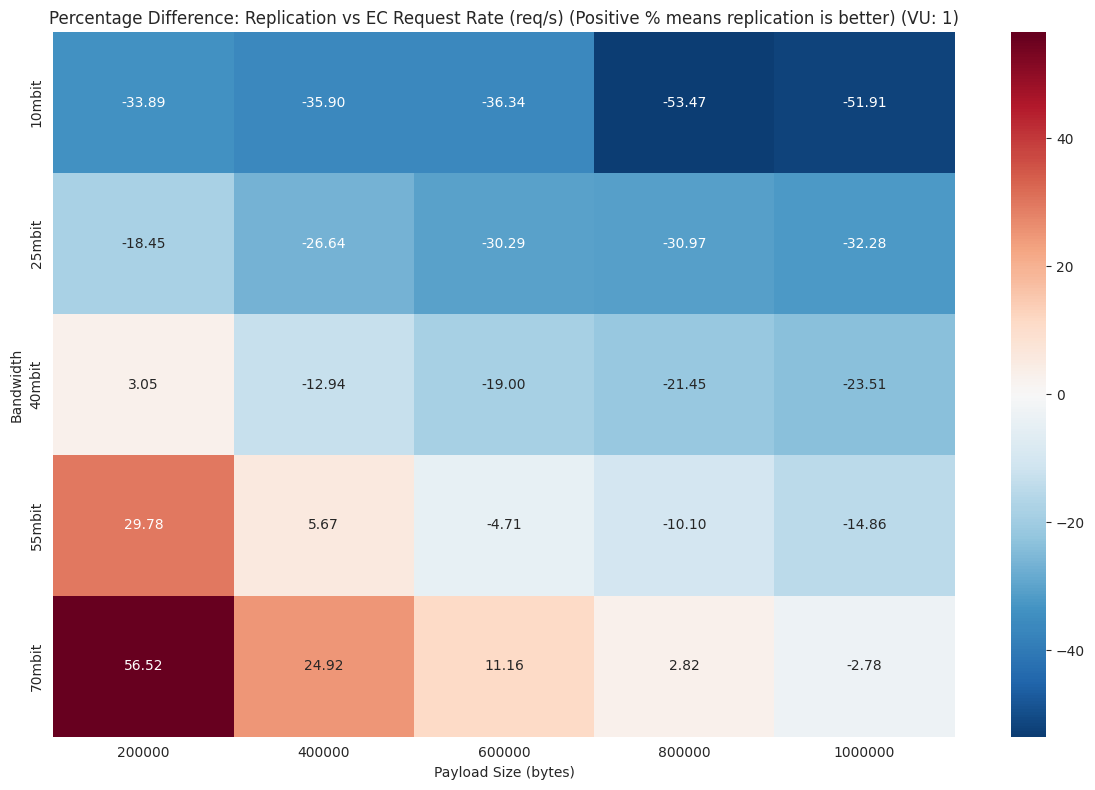

In [18]:
# 4. Create heatmaps to visualize the performance difference between EC and Replication
# This can help identify which configurations benefit most from EC vs Replication

def create_performance_diff_heatmap(metric):
    # Pivot the data to create a matrix of performance differences
    # First, create separate dataframes for EC and Replication
    df_ec = df[df['system'] == 'EC'].copy()
    df_repl = df[df['system'] == 'Replication'].copy()
    
    # Ensure we have matching rows in both dataframes
    common_conditions = pd.merge(
        df_ec[['payload_size', 'virtual_user', 'bandwidth', 'bandwidth_num']], 
        df_repl[['payload_size', 'virtual_user', 'bandwidth', 'bandwidth_num']],
        on=['payload_size', 'virtual_user', 'bandwidth', 'bandwidth_num'],
        how='inner'
    )
    
    if not common_conditions.empty:
        # Filter dataframes to include only common conditions
        df_ec_filtered = pd.merge(df_ec, common_conditions, on=['payload_size', 'virtual_user', 'bandwidth', 'bandwidth_num'])
        df_repl_filtered = pd.merge(df_repl, common_conditions, on=['payload_size', 'virtual_user', 'bandwidth', 'bandwidth_num'])
        
        # Calculate performance difference as percentage
        diff_data = []
        for _, ec_row in df_ec_filtered.iterrows():
            repl_row = df_repl_filtered[
                (df_repl_filtered['payload_size'] == ec_row['payload_size']) & 
                (df_repl_filtered['virtual_user'] == ec_row['virtual_user']) & 
                (df_repl_filtered['bandwidth'] == ec_row['bandwidth'])
            ].iloc[0]

            if metric in ['med', 'p90', 'avg']:
                # For latency: percent = (EC - Replication)/Replication *100
                denom = repl_row[metric] if repl_row[metric] != 0 else 1
                diff = (ec_row[metric] - repl_row[metric]) / denom * 100
            else:
                # For throughput: percent = (Replication - EC)/EC *100
                denom = ec_row[metric] if ec_row[metric] != 0 else 1
                diff = (repl_row[metric] - ec_row[metric]) / denom * 100

            diff_data.append({
                'payload_size': ec_row['payload_size'],
                'virtual_user': ec_row['virtual_user'],
                'bandwidth': ec_row['bandwidth'],
                'bandwidth_num': ec_row['bandwidth_num'],
                'diff': diff
            })
        diff_df = pd.DataFrame(diff_data)

        # Convert to pivot table for heatmap
        if len(diff_df['bandwidth'].unique()) > 1 and len(diff_df['payload_size'].unique()) > 1:
            # For each virtual user, create a heatmap of bandwidth vs payload size
            for vu in diff_df['virtual_user'].unique():
                vu_diff = diff_df[diff_df['virtual_user'] == vu]
                # Sort bandwidths numerically for y-axis
                bw_order = (
                    vu_diff[['bandwidth', 'bandwidth_num']]
                    .drop_duplicates()
                    .sort_values('bandwidth_num')
                    .bandwidth.tolist()
                )
                # Create pivot table
                pivot = vu_diff.pivot(index='bandwidth', columns='payload_size', values='diff').reindex(bw_order)
                # Plot heatmap
                plt.figure(figsize=(12, 8))
                sns.heatmap(pivot, annot=True, cmap='RdBu_r', center=0, fmt='.2f')

                # Indicate that values are in percent
                title_suffix = ' (Positive % means replication is better)'
                if metric in ['med', 'p90', 'avg']:
                    title_text = f'Percentage Difference: EC vs Replication {metric_titles[metric]}{title_suffix} (VU: {vu})'
                else:
                    title_text = f'Percentage Difference: Replication vs EC {metric_titles[metric]}{title_suffix} (VU: {vu})'
                plt.title(title_text)
                plt.xlabel('Payload Size (bytes)')
                plt.ylabel('Bandwidth')
                plt.tight_layout()
                plt.show()

# Create heatmaps for each metric
for metric in metrics:
    create_performance_diff_heatmap(metric)